# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention Lesson 3: Exercises

### Это третье и последнее руководство по созданию NLP с нуля, в котором мы пишем наши собственные классы и функции для предварительной обработки данных для выполнения наших задач по моделированию NLP.

### В этом проекте мы будем обучать нейронную сеть переводу с французского на английский. ... с разной степенью успеха.

### Это стало возможным благодаря простой, но действенной идее сети последовательностей, в которой две рекуррентные нейронные сети работают вместе, преобразуя одну последовательность в другую. Сеть кодировщиков преобразует входную последовательность в вектор, а сеть декодеров преобразует этот вектор в новую последовательность.

## Условие задания

1. Try with a different dataset

Another language pair

Human → Machine (e.g. IOT commands)

Chat → Response

Question → Answer

2. Replace the embeddings with pretrained word embeddings such as word2vec or GloVe

3. Try with more layers, more hidden units, and more sentences. Compare the training time and results.

4. If you use a translation file where pairs have two of the same phrase (I am test \t I am test), you can use this as an autoencoder. Try this:

Train as an autoencoder

Save only the Encoder network

Train a new Decoder for translation from there

### Импортируемые библиотеки

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
import math
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import numpy.typing as npt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### Установка метрик

In [ ]:
!pip install rouge-score sacrebleu bert_score
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

import nltk
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
nltk.download('omw-1.4')

import sacrebleu

from bert_score import score

In [ ]:
SOS_token: int = 0
EOS_token: int = 1

# ===============================
# DATA PREPARATION
# ===============================

class Lang:
    """Language vocabulary class for word-to-index mapping."""

    def __init__(self, name: str) -> None:
        self.name: str = name
        self.word2index: Dict[str, int] = {}
        self.word2count: Dict[str, int] = {}
        self.index2word: Dict[int, str] = {0: "SOS", 1: "EOS"}
        self.n_words: int = 2

    def addSentence(self, sentence: str) -> None:
        """Add all words in a sentence to the vocabulary."""
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word: str) -> None:
        """Add a word to the vocabulary."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Класс метрик

In [ ]:
def evaluate_metrics(encoder, decoder, pairs, input_lang, output_lang, n=100):
    references = []
    hypotheses = []
    for sentence, target in random.sample(pairs, n):
        output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
        hypotheses.append(' '.join(output_words))
        references.append(target)  # Keep target as string for ROUGE

    # For BLEU: convert to tokenized format
    bleu_references = [[ref.split()] for ref in references]
    bleu = corpus_bleu(bleu_references, [hyp.split() for hyp in hypotheses])

    # For ROUGE: use string format
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, hyp) for ref, hyp in zip(references, hypotheses)]
    avg_rouge1 = sum(s['rouge1'].fmeasure for s in rouge_scores) / len(rouge_scores)

    return bleu, avg_rouge1

In [ ]:
def evaluate_meteor(encoder, decoder, pairs, input_lang, output_lang, n=100):
    scores = []
    for sentence, target in random.sample(pairs, n):
        output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
        hypothesis = ' '.join(output_words)
        reference = target  # Строка, не список
        score = meteor_score([reference.split()], hypothesis.split())  # reference как list of tokens
        scores.append(score)
    return sum(scores) / len(scores)

In [ ]:
def evaluate_chrf(encoder, decoder, pairs, input_lang, output_lang, n=100):
    hypotheses = []
    references = []
    for sentence, target in random.sample(pairs, n):
        output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
        hypotheses.append(' '.join(output_words))
        references.append(target)
    chrf = sacrebleu.corpus_chrf(hypotheses, [references])  # [references] как list of lists
    return chrf.score

In [ ]:
def evaluate_bertscore(encoder, decoder, pairs, input_lang, output_lang, n=100, lang='en'):
    hypotheses = []
    references = []
    for sentence, target in random.sample(pairs, n):
        output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
        hypotheses.append(' '.join(output_words))
        references.append(target)
    P, R, F1 = score(hypotheses, references, lang=lang, verbose=True)  # lang='fr' для French refs
    return F1.mean().item()

In [ ]:
def evaluate_ter(encoder, decoder, pairs, input_lang, output_lang, n=100):
    hypotheses = []
    references = []
    for sentence, target in random.sample(pairs, n):
        output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
        hypotheses.append(' '.join(output_words))
        references.append(target)
    ter = sacrebleu.corpus_ter(hypotheses, [references])
    return ter.score  # Чем ниже, тем лучше (0 — perfect)

In [ ]:
def evaluate_perplexity(decoder_outputs, target_tensor):
    # decoder_outputs: (batch, seq, vocab), target: (batch, seq)
    loss = nn.CrossEntropyLoss(ignore_index=0)(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
    return math.exp(loss.item())  # Perplexity = exp(loss)

In [ ]:
def evaluate_bleu(
    encoder: nn.Module,
    decoder: nn.Module,
    pairs: List[List[str]],
    input_lang: Lang,
    output_lang: Lang,
    n: int = 100
) -> float:
    total_bleu = 0.0
    for _ in range(n):
        pair = random.choice(pairs)
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        reference = [pair[1].split()]
        candidate = output_words[:-1]  # Remove <EOS>
        total_bleu += sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    return total_bleu / n

## Подключаем данные с Гугл Диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Инициализируем Lang класс с SOS/EOS токеном

In [ ]:
SOS_token: int = 0
EOS_token: int = 1

# ===============================
# DATA PREPARATION
# ===============================

class Lang:
    """Language vocabulary class for word-to-index mapping."""

    def __init__(self, name: str) -> None:
        self.name: str = name
        self.word2index: Dict[str, int] = {}
        self.word2count: Dict[str, int] = {}
        self.index2word: Dict[int, str] = {0: "SOS", 1: "EOS"}
        self.n_words: int = 2

    def addSentence(self, sentence: str) -> None:
        """Add all words in a sentence to the vocabulary."""
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word: str) -> None:
        """Add a word to the vocabulary."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Вспомогательные функции для работы с текстом

In [ ]:
def unicodeToAscii(s: str) -> str:
    """Turn a Unicode string to plain ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s: str) -> str:
    """Lowercase, trim, and remove non-letter characters."""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()


def readLangs(lang1: str, lang2: str, reverse: bool = False) -> Tuple[Lang, Lang, List[List[str]]]:
    """Read language pairs from file."""
    print("Reading lines...")

    lines: List[str] = open('/content/drive/MyDrive/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs: List[List[str]] = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang: Lang = Lang(lang2)
        output_lang: Lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

### Вспомогательные функции для работы с текстом - 2 версии из-за разницы в выборочных данных (filterPair/filterPair_2)

In [ ]:
MAX_LENGTH: int = 10

eng_prefixes: Tuple[str, ...] = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p: List[str]) -> bool:
    """Check if a pair meets filtering criteria."""
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPair_2(p: List[str]) -> bool:
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs: List[List[str]]) -> List[List[str]]:
    """Filter pairs based on length and prefix criteria."""
    return [pair for pair in pairs if filterPair(pair)]

def filterPairs_2(pairs: List[List[str]]) -> List[List[str]]:
    """Filter pairs based on length and prefix criteria."""
    return [pair for pair in pairs if filterPair_2(pair)]


def prepareData(lang1: str, lang2: str, reverse: bool = False) -> Tuple[Lang, Lang, List[List[str]]]:
    """Prepare data by reading, filtering, and building vocabulary."""
    input_lang: Lang
    output_lang: Lang
    pairs: List[List[str]]
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def prepareData_2(lang1: str, lang2: str, reverse: bool = False) -> Tuple[Lang, Lang, List[List[str]]]:
    """Prepare data by reading, filtering, and building vocabulary."""
    input_lang: Lang
    output_lang: Lang
    pairs: List[List[str]]
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs_2(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

### Создание эмбеддингов

In [ ]:
# ===============================
# PRETRAINED EMBEDDINGS
# ===============================

def load_pretrained_embeddings(
    lang: Lang,
    embedding_file: str,
    embedding_dim: int = 300
) -> Optional[torch.Tensor]:
    """
    Load pretrained embeddings (GloVe format).

    Expected format: word dim1 dim2 ... dimN
    Example: the 0.418 0.24968 -0.41242 ...
    """
    embeddings: Dict[str, List[float]] = {}

    try:
        with open(embedding_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector

        print(f"Loaded {len(embeddings)} word vectors")

        # Create embedding matrix
        embedding_matrix = np.random.randn(lang.n_words, embedding_dim).astype(np.float32)
        embedding_matrix *= 0.01  # Small random initialization

        # Fill in pretrained embeddings
        found = 0
        for word, idx in lang.word2index.items():
            if word in embeddings:
                embedding_matrix[idx] = embeddings[word]
                found += 1

        print(f"Found pretrained embeddings for {found}/{lang.n_words} words")

        return torch.from_numpy(embedding_matrix)

    except FileNotFoundError:
        print(f"Pretrained embeddings file not found: {embedding_file}")
        print("Using random initialization instead")
        return None

### Объявление архитектур моделей с использованием разных механизмов внимания

In [ ]:
# ===============================
# MODEL ARCHITECTURES
# ===============================

#===========================================================================================
# Модель 1: Базовая RNN модель с претреннингом, GRU и Dropout
#===========================================================================================

class EncoderRNN(nn.Module):
    """Encoder RNN with embedding and GRU."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size: int = hidden_size

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False  # Allow fine-tuning
            )
        else:
            self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru: nn.GRU = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))
        output: torch.Tensor
        hidden: torch.Tensor
        output, hidden = self.gru(embedded)
        return output, hidden

#===========================================================================================
# Модель 2: Deep RNN модель с претреннингом, Большим GRU и Dropout
#===========================================================================================

class DeepEncoderRNN(nn.Module):
    """Deep encoder with multiple GRU layers."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepEncoderRNN, self).__init__()
        self.hidden_size: int = hidden_size
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru: nn.GRU = nn.GRU(
            hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))
        output: torch.Tensor
        hidden: torch.Tensor
        output, hidden = self.gru(embedded)
        return output, hidden

#===========================================================================================
# Механизм внимания 1: BahdanauAttention с линейными слоями Wa, Ua, Va
#===========================================================================================

class BahdanauAttention(nn.Module):
    """Bahdanau attention mechanism."""

    def __init__(self, hidden_size: int) -> None:
        super(BahdanauAttention, self).__init__()
        self.Wa: nn.Linear = nn.Linear(hidden_size, hidden_size)
        self.Ua: nn.Linear = nn.Linear(hidden_size, hidden_size)
        self.Va: nn.Linear = nn.Linear(hidden_size, 1)

    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        scores: torch.Tensor = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights: torch.Tensor = F.softmax(scores, dim=-1)
        context: torch.Tensor = torch.bmm(weights, keys)

        return context, weights

#===========================================================================================
# Decoder 1: AttnDecoderRNN с претреннингом, BahdanauAttention, GRU, Linear и Dropout
#===========================================================================================

class AttnDecoderRNN_1(nn.Module):
    """Decoder RNN with Bahdanau attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(AttnDecoderRNN_1, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: BahdanauAttention = BahdanauAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        query: torch.Tensor = hidden.permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class AttnDecoderRNN_2(nn.Module):
    """Decoder RNN with LuongAttention attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(AttnDecoderRNN_2, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: LuongAttention = LuongAttention(hidden_size, method='general')
        self.gru: nn.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        query: torch.Tensor = hidden.permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class AttnDecoderRNN_3(nn.Module):
    """Decoder RNN with ScaledDotProductAttention attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(AttnDecoderRNN_3, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: ScaledDotProductAttention = ScaledDotProductAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        query: torch.Tensor = hidden.permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights


class AttnDecoderRNN_4(nn.Module):
    """Decoder RNN with MultiplicativeAttention attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(AttnDecoderRNN_4, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: MultiplicativeAttention = MultiplicativeAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        query: torch.Tensor = hidden.permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class AttnDecoderRNN_5(nn.Module):
    """Decoder RNN with SelfAttention attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(AttnDecoderRNN_5, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: SelfAttention = SelfAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        query: torch.Tensor = hidden.permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

#===========================================================================================
# Decoder 2: DeepAttnDecoderRNN с претреннингом, BahdanauAttention, GRU, Linear и Dropout
#===========================================================================================

class DeepAttnDecoderRNN_1(nn.Module):
    """Deep decoder with multiple layers and attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepAttnDecoderRNN_1, self).__init__()
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: BahdanauAttention = BahdanauAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(
            2 * hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Expand encoder hidden for multiple layers
        if encoder_hidden.size(0) != self.n_layers:
            decoder_hidden = encoder_hidden.repeat(self.n_layers, 1, 1)
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        # Use last layer's hidden state for attention
        query: torch.Tensor = hidden[-1:].permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights


class DeepAttnDecoderRNN_2(nn.Module):
    """Deep decoder with multiple layers and attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepAttnDecoderRNN_2, self).__init__()
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: LuongAttention = LuongAttention(hidden_size, method='general')
        self.gru: nn.GRU = nn.GRU(
            2 * hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Expand encoder hidden for multiple layers
        if encoder_hidden.size(0) != self.n_layers:
            decoder_hidden = encoder_hidden.repeat(self.n_layers, 1, 1)
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        # Use last layer's hidden state for attention
        query: torch.Tensor = hidden[-1:].permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class DeepAttnDecoderRNN_3(nn.Module):
    """Deep decoder with multiple layers and attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepAttnDecoderRNN_3, self).__init__()
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: ScaledDotProductAttention = ScaledDotProductAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(
            2 * hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Expand encoder hidden for multiple layers
        if encoder_hidden.size(0) != self.n_layers:
            decoder_hidden = encoder_hidden.repeat(self.n_layers, 1, 1)
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        # Use last layer's hidden state for attention
        query: torch.Tensor = hidden[-1:].permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class DeepAttnDecoderRNN_4(nn.Module):
    """Deep decoder with multiple layers and attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepAttnDecoderRNN_4, self).__init__()
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: MultiplicativeAttention = MultiplicativeAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(
            2 * hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Expand encoder hidden for multiple layers
        if encoder_hidden.size(0) != self.n_layers:
            decoder_hidden = encoder_hidden.repeat(self.n_layers, 1, 1)
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        # Use last layer's hidden state for attention
        query: torch.Tensor = hidden[-1:].permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class DeepAttnDecoderRNN_5(nn.Module):
    """Deep decoder with multiple layers and attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepAttnDecoderRNN_5, self).__init__()
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: SelfAttention = SelfAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(
            2 * hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Expand encoder hidden for multiple layers
        if encoder_hidden.size(0) != self.n_layers:
            decoder_hidden = encoder_hidden.repeat(self.n_layers, 1, 1)
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        # Use last layer's hidden state for attention
        query: torch.Tensor = hidden[-1:].permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

#===========================================================================================
# Механизм внимания 2: LuongAttention с линейными слоями Wa / Wa + Va
#===========================================================================================

class LuongAttention(nn.Module):
    """Luong attention mechanism (Dot, General, Concat)."""

    def __init__(self, hidden_size: int, method: str = 'general') -> None:
        super(LuongAttention, self).__init__()
        self.method = method
        if self.method == 'general':
            self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        elif self.method == 'concat':
            self.Wa = nn.Linear(hidden_size * 2, hidden_size)
            self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # query: (batch, 1, hidden_size), keys: (batch, seq_len, hidden_size)
        if self.method == 'dot':
            scores = torch.bmm(query, keys.transpose(1, 2))  # (batch, 1, seq_len)
        elif self.method == 'general':
            scores = torch.bmm(self.Wa(query), keys.transpose(1, 2))  # (batch, 1, seq_len)
        elif self.method == 'concat':
            batch_size, seq_len = keys.size(0), keys.size(1)
            query_expanded = query.repeat(1, seq_len, 1)  # (batch, seq_len, hidden_size)
            concat = torch.cat((query_expanded, keys), dim=2)  # (batch, seq_len, 2*hidden_size)
            scores = self.Va(torch.tanh(self.Wa(concat)))  # (batch, seq_len, 1)
            scores = scores.transpose(1, 2)  # (batch, 1, seq_len)

        weights = F.softmax(scores, dim=-1)  # (batch, 1, seq_len)
        context = torch.bmm(weights, keys)  # (batch, 1, hidden_size)
        return context, weights

#===========================================================================================
# Механизм внимания 3: ScaledDotProductAttention
#===========================================================================================
class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention from Transformer."""

    def __init__(self, hidden_size: int) -> None:
        super(ScaledDotProductAttention, self).__init__()
        self.scale = math.sqrt(hidden_size)

    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # query: (batch, 1, hidden_size), keys: (batch, seq_len, hidden_size)
        scores = torch.bmm(query, keys.transpose(1, 2)) / self.scale  # (batch, 1, seq_len)
        weights = F.softmax(scores, dim=-1)  # (batch, 1, seq_len)
        context = torch.bmm(weights, keys)  # (batch, 1, hidden_size)
        return context, weights

#===========================================================================================
# Механизм внимания 4: MultiplicativeAttention с линейным слоем W
#===========================================================================================
class MultiplicativeAttention(nn.Module):
    """Multiplicative attention with single weight matrix."""

    def __init__(self, hidden_size: int) -> None:
        super(MultiplicativeAttention, self).__init__()
        self.W = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # query: (batch, 1, hidden_size), keys: (batch, seq_len, hidden_size)
        scores = torch.bmm(query, self.W(keys).transpose(1, 2))  # (batch, 1, seq_len)
        weights = F.softmax(scores, dim=-1)  # (batch, 1, seq_len)
        context = torch.bmm(weights, keys)  # (batch, 1, hidden_size)
        return context, weights

#===========================================================================================
# Механизм внимания 5: SelfAttention с линейным слоем Wq, Wk, Wv и scale
#===========================================================================================
class SelfAttention(nn.Module):
    """Self-Attention for autoencoder."""

    def __init__(self, hidden_size: int) -> None:
        super(SelfAttention, self).__init__()
        self.Wq = nn.Linear(hidden_size, hidden_size)
        self.Wk = nn.Linear(hidden_size, hidden_size)
        self.Wv = nn.Linear(hidden_size, hidden_size)
        self.scale = math.sqrt(hidden_size)

    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # query: (batch, 1, hidden_size), keys: (batch, seq_len, hidden_size)
        Q = self.Wq(keys)  # Use keys as query source for self-attention
        K = self.Wk(keys)
        V = self.Wv(keys)
        scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale  # (batch, seq_len, seq_len)
        weights = F.softmax(scores, dim=-1)  # (batch, seq_len, seq_len)
        context = torch.bmm(weights, V)  # (batch, seq_len, hidden_size)
        # Reduce to match decoder input (take last position or mean)
        context = context[:, -1:, :]  # (batch, 1, hidden_size)
        weights = weights[:, -1:, :]  # (batch, 1, seq_len)
        return context, weights

### Функция получения датасета и его загрузка для обучения (2 версии в зависимости от функции FilterPath)

In [ ]:
# ===============================
# TRAINING & EVALUATION
# ===============================

def get_dataloader(batch_size: int,
                   lang1: str = 'eng',
                   lang2: str = 'fra',
                   reverse: bool = False) -> Tuple[Lang, Lang, DataLoader, List[List[str]]]:
    """Create DataLoader for training."""
    input_lang_local: Lang
    output_lang_local: Lang
    pairs_local: List[List[str]]
    input_lang_local, output_lang_local, pairs_local = prepareData(lang1, lang2, reverse=True)

    n: int = len(pairs_local)
    input_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs_local):
        inp_ids: List[int] = [input_lang_local.word2index[word] for word in inp.split(' ')]
        tgt_ids: List[int] = [output_lang_local.word2index[word] for word in tgt.split(' ')]
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data: TensorDataset = TensorDataset(
        torch.LongTensor(input_ids).to(device),
        torch.LongTensor(target_ids).to(device)
    )

    train_sampler: RandomSampler = RandomSampler(train_data)
    train_dataloader: DataLoader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang_local, output_lang_local, train_dataloader, pairs_local

def get_dataloader_2(batch_size: int,
                   lang1: str = 'eng',
                   lang2: str = 'fra',
                   reverse: bool = False) -> Tuple[Lang, Lang, DataLoader, List[List[str]]]:
    """Create DataLoader for training."""
    input_lang_local: Lang
    output_lang_local: Lang
    pairs_local: List[List[str]]
    input_lang_local, output_lang_local, pairs_local = prepareData_2(lang1, lang2, reverse=True)

    n: int = len(pairs_local)
    input_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs_local):
        inp_ids: List[int] = [input_lang_local.word2index[word] for word in inp.split(' ')]
        tgt_ids: List[int] = [output_lang_local.word2index[word] for word in tgt.split(' ')]
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data: TensorDataset = TensorDataset(
        torch.LongTensor(input_ids).to(device),
        torch.LongTensor(target_ids).to(device)
    )

    train_sampler: RandomSampler = RandomSampler(train_data)
    train_dataloader: DataLoader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang_local, output_lang_local, train_dataloader, pairs_local

### Основные функции для тренировки - train по эпохам

In [ ]:
def train_epoch(
    dataloader: DataLoader,
    encoder: nn.Module,
    decoder: nn.Module,
    encoder_optimizer: optim.Optimizer,
    decoder_optimizer: optim.Optimizer,
    criterion: nn.Module
) -> float:
    """Train for one epoch."""
    total_loss: float = 0.0
    for data in dataloader:
        input_tensor: torch.Tensor
        target_tensor: torch.Tensor
        input_tensor, target_tensor = data

        if encoder_optimizer:
            encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs: torch.Tensor
        encoder_hidden: torch.Tensor
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs: torch.Tensor
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss: torch.Tensor = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        # Gradient clipping
        if encoder_optimizer:
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            encoder_optimizer.step()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
def train(
    train_dataloader: DataLoader,
    encoder: nn.Module,
    decoder: nn.Module,
    n_epochs: int,
    learning_rate: float = 0.001,
    print_every: int = 10,
    train_encoder: bool = True
) -> List[float]:
    """Train the model."""
    start: float = time.time()
    losses: List[float] = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate) if train_encoder else None
    decoder_optimizer: optim.Adam = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion: nn.NLLLoss = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss: float = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        losses.append(loss)

        if epoch % print_every == 0:
            elapsed = time.time() - start
            print(f'Epoch {epoch}/{n_epochs} ({epoch/n_epochs*100:.0f}%) - Loss: {loss:.4f} - Time: {elapsed:.0f}s')

    return losses


def evaluate(
    encoder: nn.Module,
    decoder: nn.Module,
    sentence: str,
    input_lang: Lang,
    output_lang: Lang
) -> Tuple[List[str], Optional[torch.Tensor]]:
    """Evaluate a single sentence."""
    with torch.no_grad():
        indexes: List[int] = [input_lang.word2index[word] for word in sentence.split(' ') if word in input_lang.word2index]
        indexes.append(EOS_token)
        input_tensor: torch.Tensor = torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

        encoder_outputs: torch.Tensor
        encoder_hidden: torch.Tensor
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs: torch.Tensor
        decoder_attn: Optional[torch.Tensor]
        decoder_outputs, _, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _: torch.Tensor
        topi: torch.Tensor
        _, topi = decoder_outputs.topk(1)
        decoded_ids: torch.Tensor = topi.squeeze()

        decoded_words: List[str] = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words, decoder_attn

In [ ]:
def evaluate_bleu(
    encoder: nn.Module,
    decoder: nn.Module,
    pairs: List[List[str]],
    input_lang: Lang,
    output_lang: Lang,
    n: int = 100
) -> float:
    total_bleu = 0.0
    for _ in range(n):
        pair = random.choice(pairs)
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        reference = [pair[1].split()]
        candidate = output_words[:-1]  # Remove <EOS>
        total_bleu += sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    return total_bleu / n

## Эксперименты

## Experiment 1: Baseline с использованием оригинальной архитектуры и разными механизмами внимания

In [ ]:
input_lang, output_lang, train_dataloader, pairs = get_dataloader(32)
# Test
test_sentences = [
    'je suis trop fatigue',
    'il est tres grand',
    'elle est belle'
]

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [26]:
print("\n" + "="*70)
print("EXPERIMENT 1: Baseline (Original Architecture with BahdanauAttention)")
print("="*70)

input_lang, output_lang, train_dataloader, pairs = get_dataloader(32)

encoder1 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder1 = AttnDecoderRNN_1(128, output_lang.n_words).to(device)

losses1 = train(train_dataloader, encoder1, decoder1, 100, learning_rate=0.001, print_every=10)

encoder1.eval()
decoder1.eval()

# Test
test_sentences = [
    'je suis trop fatigue',
    'il est tres grand',
    'elle est belle'
]

print("\nTest Results (Baseline):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder1, decoder1, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 1: Baseline (Original Architecture with BahdanauAttention)
Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
Epoch 10/100 (10%) - Loss: 0.4862 - Time: 84s
Epoch 20/100 (20%) - Loss: 0.1514 - Time: 167s
Epoch 30/100 (30%) - Loss: 0.0758 - Time: 249s
Epoch 40/100 (40%) - Loss: 0.0492 - Time: 331s
Epoch 50/100 (50%) - Loss: 0.0398 - Time: 414s
Epoch 60/100 (60%) - Loss: 0.0356 - Time: 498s
Epoch 70/100 (70%) - Loss: 0.0317 - Time: 583s
Epoch 80/100 (80%) - Loss: 0.0291 - Time: 665s
Epoch 90/100 (90%) - Loss: 0.0281 - Time: 748s
Epoch 100/100 (100%) - Loss: 0.0258 - Time: 831s

Test Results (Baseline):
  je suis trop fatigue -> i am too tired tired <EOS>
  il est tres grand -> of very tall <EOS>
  elle est belle -> she s beautiful beautiful beautiful <EOS>


#### TEST 1: Result loss: 0.0258, Time: 831s.

### Baseline (Original Architecture with BahdanauAttention) - Metrics

In [27]:
import pandas as pd
bleu1, rouge1 = evaluate_metrics(encoder1, decoder1, pairs, input_lang, output_lang, n=100)
metrics_encoderRNN_Bahdanau = {
    'BLEU': evaluate_bleu(encoder1, decoder1, pairs, input_lang, output_lang),
    'BLEU2': bleu1,
    'ROUGE-1': rouge1,
    'METEOR': evaluate_meteor(encoder1, decoder1, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder1, decoder1, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder1, decoder1, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder1, decoder1, pairs, input_lang, output_lang)
}
df_metrics_encoderRNN_Bahdanau = pd.DataFrame.from_dict(metrics_encoderRNN_Bahdanau, orient='index', columns=['Score'])
print(df_metrics_encoderRNN_Bahdanau)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.50 seconds, 199.66 sentences/sec
               Score
BLEU        0.794536
BLEU2       0.680571
ROUGE-1     0.825246
METEOR      0.905404
chrF       91.308258
BERTScore   0.929407
TER        24.208566


In [28]:
print("\n" + "="*70)
print("EXPERIMENT 2: Baseline (Original Architecture with LuongAttention)")
print("="*70)

encoder2 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder2 = AttnDecoderRNN_2(128, output_lang.n_words).to(device)

losses2 = train(train_dataloader, encoder2, decoder2, 100, learning_rate=0.001, print_every=10)

encoder2.eval()
decoder2.eval()

print("\nTest Results (Baseline):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder2, decoder2, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 2: Baseline (Original Architecture with )
Epoch 10/100 (10%) - Loss: 0.6787 - Time: 71s
Epoch 20/100 (20%) - Loss: 0.2592 - Time: 142s
Epoch 30/100 (30%) - Loss: 0.1198 - Time: 213s
Epoch 40/100 (40%) - Loss: 0.0705 - Time: 284s
Epoch 50/100 (50%) - Loss: 0.0509 - Time: 355s
Epoch 60/100 (60%) - Loss: 0.0420 - Time: 426s
Epoch 70/100 (70%) - Loss: 0.0377 - Time: 497s
Epoch 80/100 (80%) - Loss: 0.0345 - Time: 568s
Epoch 90/100 (90%) - Loss: 0.0349 - Time: 640s
Epoch 100/100 (100%) - Loss: 0.0302 - Time: 711s

Test Results (Baseline):
  je suis trop fatigue -> i am tired to do just tired <EOS>
  il est tres grand -> he is very tall and lazy <EOS>
  elle est belle -> she is much better than beautiful <EOS>


#### TEST 2: Result loss: 0.0302, Time: 711s.

### Baseline (Original Architecture with LuongAttention) - Metrics

In [29]:
bleu2, rouge2 = evaluate_metrics(encoder2, decoder2, pairs, input_lang, output_lang, n=100)
metrics_encoderRNN_LuongAttention = {
    'BLEU': evaluate_bleu(encoder2, decoder2, pairs, input_lang, output_lang),
    'BLEU2': bleu2,
    'ROUGE-1': rouge2,
    'METEOR': evaluate_meteor(encoder2, decoder2, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder2, decoder2, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder2, decoder2, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder2, decoder2, pairs, input_lang, output_lang)
}
df_metrics_encoderRNN_LuongAttention = pd.DataFrame.from_dict(metrics_encoderRNN_LuongAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNN_LuongAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.23 seconds, 425.72 sentences/sec
               Score
BLEU        0.752333
BLEU2       0.650897
ROUGE-1     0.835518
METEOR      0.916569
chrF       86.943291
BERTScore   0.928610
TER        32.678571


In [30]:
print("\n" + "="*70)
print("EXPERIMENT 3: Baseline (Original Architecture with ScaledDotProductAttention)")
print("="*70)

encoder3 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder3 = AttnDecoderRNN_3(128, output_lang.n_words).to(device)

losses3 = train(train_dataloader, encoder3, decoder3, 100, learning_rate=0.001, print_every=10)

encoder3.eval()
decoder3.eval()

print("\nTest Results (Baseline):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder3, decoder3, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 3: Baseline (Original Architecture with ScaledDotProductAttention)
Epoch 10/100 (10%) - Loss: 0.5840 - Time: 67s
Epoch 20/100 (20%) - Loss: 0.2100 - Time: 134s
Epoch 30/100 (30%) - Loss: 0.1004 - Time: 201s
Epoch 40/100 (40%) - Loss: 0.0636 - Time: 268s
Epoch 50/100 (50%) - Loss: 0.0455 - Time: 335s
Epoch 60/100 (60%) - Loss: 0.0384 - Time: 402s
Epoch 70/100 (70%) - Loss: 0.0340 - Time: 469s
Epoch 80/100 (80%) - Loss: 0.0319 - Time: 536s
Epoch 90/100 (90%) - Loss: 0.0292 - Time: 603s
Epoch 100/100 (100%) - Loss: 0.0275 - Time: 670s

Test Results (Baseline):
  je suis trop fatigue -> i m too tired too <EOS>
  il est tres grand -> he s very tall <EOS>
  elle est belle -> she s handsome <EOS>


#### TEST 3: Result loss: 0.0275, Time: 670s.

### Baseline (Original Architecture with ScaledDotProductAttention) - Metrics

In [31]:
bleu3, rouge3 = evaluate_metrics(encoder3, decoder3, pairs, input_lang, output_lang, n=100)
metrics_encoderRNN_ScaledDotProductAttention = {
    'BLEU': evaluate_bleu(encoder3, decoder3, pairs, input_lang, output_lang),
    'BLEU2': bleu3,
    'ROUGE-1': rouge3,
    'METEOR': evaluate_meteor(encoder3, decoder3, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder3, decoder3, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder3, decoder3, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder3, decoder3, pairs, input_lang, output_lang)
}
df_metrics_encoderRNN_ScaledDotProductAttention = pd.DataFrame.from_dict(metrics_encoderRNN_ScaledDotProductAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNN_ScaledDotProductAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.23 seconds, 432.31 sentences/sec
               Score
BLEU        0.758623
BLEU2       0.634428
ROUGE-1     0.832134
METEOR      0.911137
chrF       85.697527
BERTScore   0.926253
TER        31.166348


In [32]:
print("\n" + "="*70)
print("EXPERIMENT 4: Baseline (Original Architecture with MultiplicativeAttention)")
print("="*70)

encoder4 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder4 = AttnDecoderRNN_4(128, output_lang.n_words).to(device)

losses4 = train(train_dataloader, encoder4, decoder4, 100, learning_rate=0.001, print_every=10)

encoder4.eval()
decoder4.eval()

print("\nTest Results (Baseline):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder4, decoder4, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 4: Baseline (Original Architecture with MultiplicativeAttention)
Epoch 10/100 (10%) - Loss: 0.6694 - Time: 72s
Epoch 20/100 (20%) - Loss: 0.2710 - Time: 145s
Epoch 30/100 (30%) - Loss: 0.1284 - Time: 218s
Epoch 40/100 (40%) - Loss: 0.0768 - Time: 291s
Epoch 50/100 (50%) - Loss: 0.0566 - Time: 363s
Epoch 60/100 (60%) - Loss: 0.0475 - Time: 437s
Epoch 70/100 (70%) - Loss: 0.0413 - Time: 509s
Epoch 80/100 (80%) - Loss: 0.0386 - Time: 582s
Epoch 90/100 (90%) - Loss: 0.0355 - Time: 655s
Epoch 100/100 (100%) - Loss: 0.0330 - Time: 728s

Test Results (Baseline):
  je suis trop fatigue -> i m too tired to walk i remember <EOS>
  il est tres grand -> he is very tall and great <EOS>
  elle est belle -> she is beautiful to beautiful <EOS>


#### TEST 4: Result loss: 0.0330, Time: 728s.

### Baseline (Original Architecture with MultiplicativeAttention) - Metrics

In [33]:
bleu4, rouge4 = evaluate_metrics(encoder4, decoder4, pairs, input_lang, output_lang, n=100)
metrics_encoderRNN_MultiplicativeAttention = {
    'BLEU': evaluate_bleu(encoder4, decoder4, pairs, input_lang, output_lang),
    'BLEU2': bleu4,
    'ROUGE-1': rouge4,
    'METEOR': evaluate_meteor(encoder4, decoder4, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder4, decoder4, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder4, decoder4, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder4, decoder4, pairs, input_lang, output_lang)
}
df_metrics_encoderRNN_MultiplicativeAttention = pd.DataFrame.from_dict(metrics_encoderRNN_MultiplicativeAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNN_MultiplicativeAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 415.41 sentences/sec
               Score
BLEU        0.622411
BLEU2       0.496869
ROUGE-1     0.738026
METEOR      0.844831
chrF       75.729533
BERTScore   0.912539
TER        49.532710


In [34]:
print("\n" + "="*70)
print("EXPERIMENT 5: Baseline (Original Architecture with SelfAttention)")
print("="*70)

encoder5 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder5 = AttnDecoderRNN_5(128, output_lang.n_words).to(device)

losses5 = train(train_dataloader, encoder5, decoder5, 100, learning_rate=0.001, print_every=10)

encoder5.eval()
decoder5.eval()

print("\nTest Results (Baseline):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder5, decoder5, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 5: Baseline (Original Architecture with SelfAttention)
Epoch 10/100 (10%) - Loss: 0.6631 - Time: 98s
Epoch 20/100 (20%) - Loss: 0.2667 - Time: 196s
Epoch 30/100 (30%) - Loss: 0.1293 - Time: 294s
Epoch 40/100 (40%) - Loss: 0.0813 - Time: 392s
Epoch 50/100 (50%) - Loss: 0.0607 - Time: 490s
Epoch 60/100 (60%) - Loss: 0.0510 - Time: 588s
Epoch 70/100 (70%) - Loss: 0.0447 - Time: 687s
Epoch 80/100 (80%) - Loss: 0.0425 - Time: 786s
Epoch 90/100 (90%) - Loss: 0.0397 - Time: 884s
Epoch 100/100 (100%) - Loss: 0.0383 - Time: 982s

Test Results (Baseline):
  je suis trop fatigue -> i m too tired <EOS>
  il est tres grand -> he s very tall <EOS>
  elle est belle -> she s a beautiful person <EOS>


#### TEST 5: Result loss: 0.0383, Time: 982s.

### Baseline (Original Architecture with SelfAttention) - Metrics

In [35]:
bleu5, rouge5 = evaluate_metrics(encoder5, decoder5, pairs, input_lang, output_lang, n=100)
metrics_encoderRNN_SelfAttention = {
    'BLEU': evaluate_bleu(encoder5, decoder5, pairs, input_lang, output_lang),
    'BLEU2': bleu5,
    'ROUGE-1': rouge5,
    'METEOR': evaluate_meteor(encoder5, decoder5, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder5, decoder5, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder5, decoder5, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder5, decoder5, pairs, input_lang, output_lang)
}
df_metrics_encoderRNN_SelfAttention = pd.DataFrame.from_dict(metrics_encoderRNN_SelfAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNN_SelfAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 415.33 sentences/sec
               Score
BLEU        0.768055
BLEU2       0.620076
ROUGE-1     0.808356
METEOR      0.882593
chrF       81.517201
BERTScore   0.925824
TER        35.408560


### Сравнение Baseline моделей RNNEncoder с разными механизмами внимания

In [36]:
# ===============================
# COMPARISON
# ===============================

print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

print("\nFinal Losses:")
print(f"  Baseline (BahdanauAttention):     {losses1[-1]:.4f}")
print(f"  Baseline (LuongAttention): {losses2[-1]:.4f}")
print(f"  Baseline (ScaledDotProductAttention): {losses3[-1]:.4f}")
print(f"  Baseline (MultiplicativeAttention):  {losses4[-1]:.4f}")
print(f"  Baseline (SelfAttention):  {losses5[-1]:.4f}")



RESULTS COMPARISON

Final Losses:
  Baseline (BahdanauAttention):     0.0258
  Baseline (LuongAttention): 0.0302
  Baseline (ScaledDotProductAttention): 0.0275
  Baseline (MultiplicativeAttention):  0.0330
  Baseline (SelfAttention):  0.0383


### График loss-функции Baseline моделей RNNEncoder с разными механизмами внимания

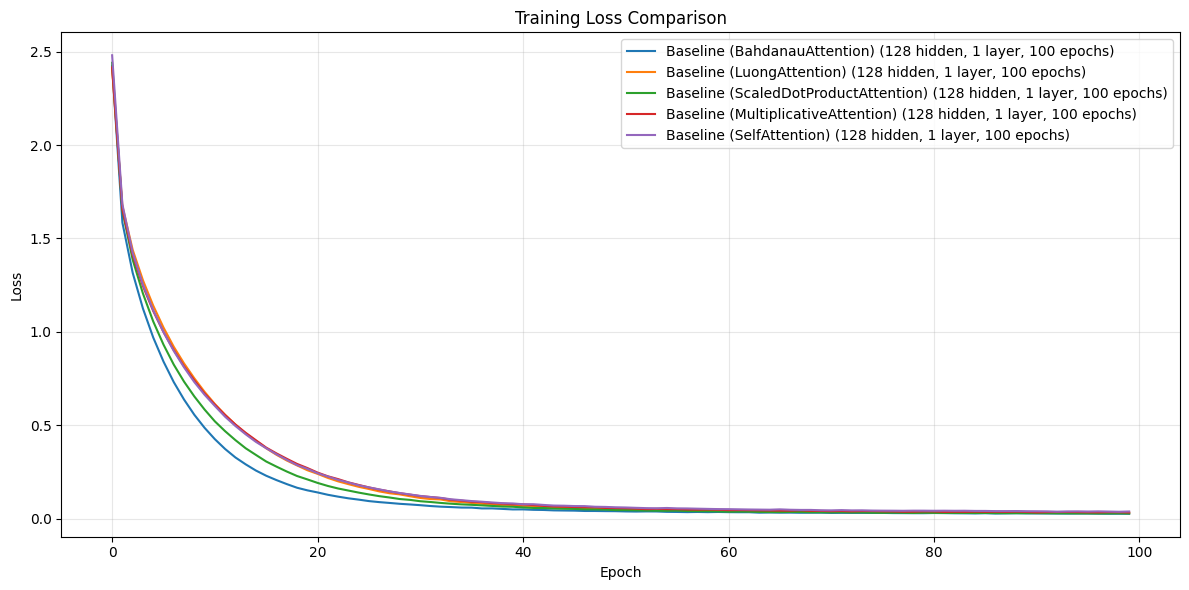

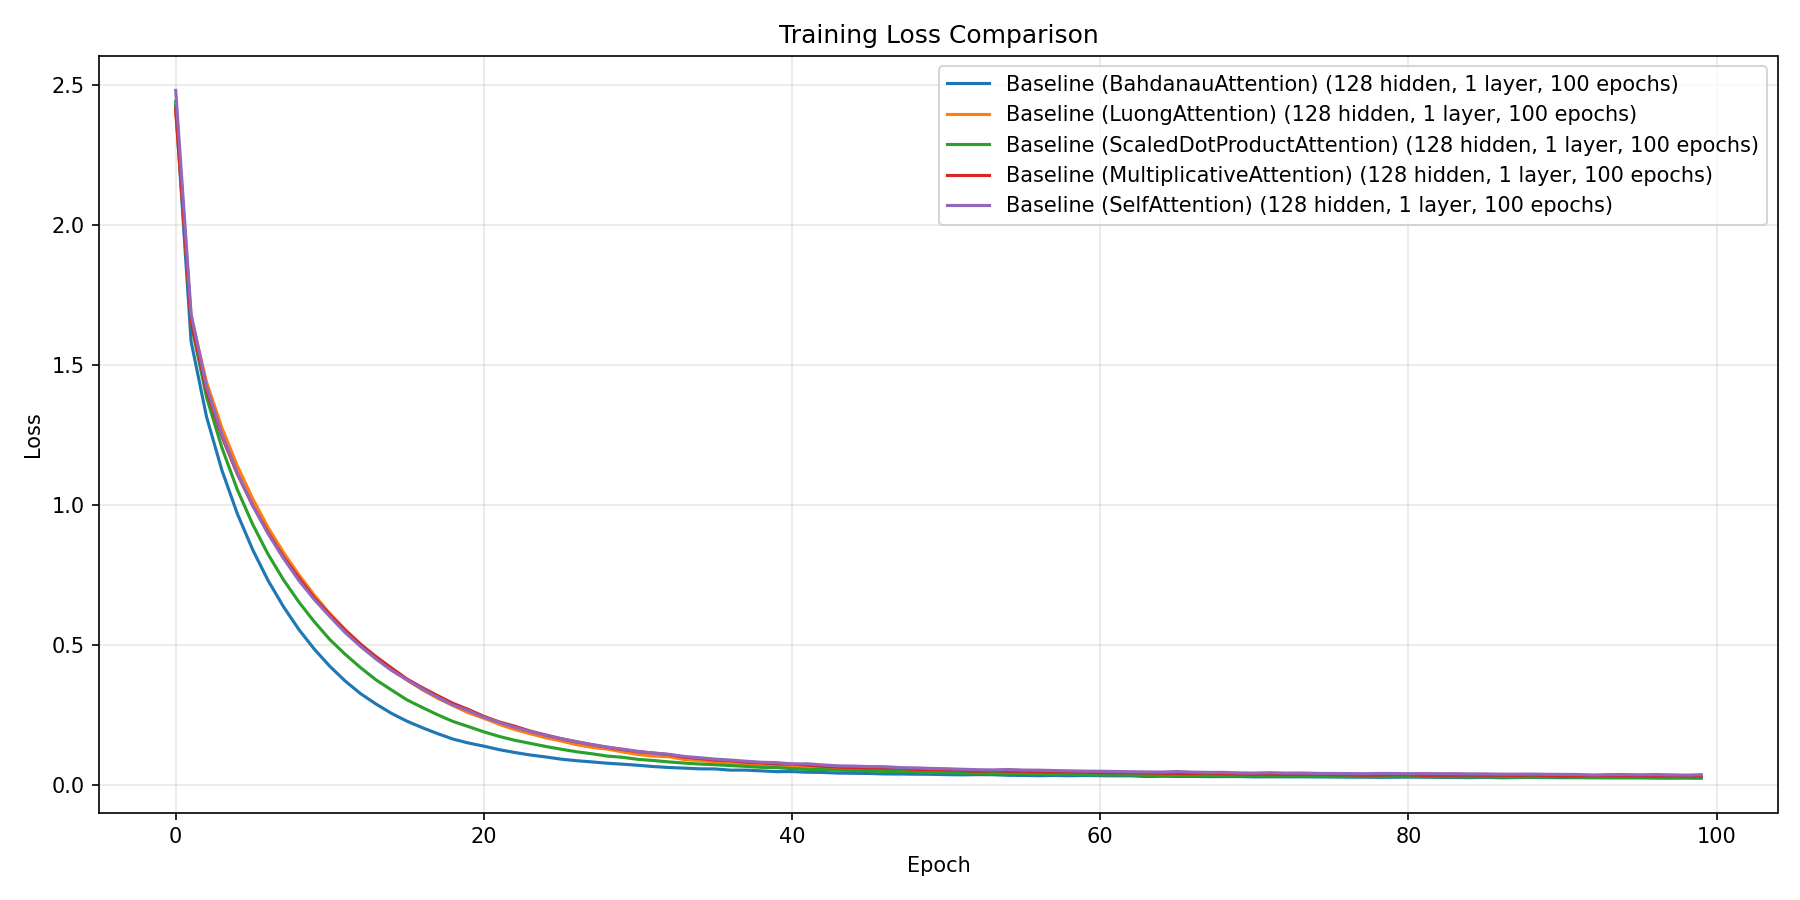

In [37]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

plt.figure(figsize=(12, 6))
plt.plot(losses1, label='Baseline (BahdanauAttention) (128 hidden, 1 layer, 100 epochs)')
plt.plot(losses2, label='Baseline (LuongAttention) (128 hidden, 1 layer, 100 epochs)')
plt.plot(losses3, label='Baseline (ScaledDotProductAttention) (128 hidden, 1 layer, 100 epochs)')
plt.plot(losses4, label='Baseline (MultiplicativeAttention) (128 hidden, 1 layer, 100 epochs)')
plt.plot(losses5, label='Baseline (SelfAttention) (128 hidden, 1 layer, 100 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison(1).png', dpi=150)
plt.show()
display(Image(filename='comparison(1).png'))

### Промежуточные результаты по выбору наиболее точной модели

| Модель | Итоговый loss | BLEU | BLEU2 | ROUGE-1 | METEOR | chrF | BERTScore | TER
|--|--|--|--|--|--|--|--|--|
|Baseline (BahdanauAttention)|0.0258|0.794536|0.680571|0.825246|0.905404|91.308258|0.929407|24.208566|
|Baseline (LuongAttention)|0.0302|0.752333|0.650897|0.835518|0.916569|86.943291|0.928610|32.678571|
|Baseline (ScaledDotProductAttention)|0.0275|0.758623|0.634428|0.832134|0.911137|85.697527|0.926253|31.166348|
|Baseline (MultiplicativeAttention)|0.0330|0.622411|0.496869|0.738026|0.844831|75.729533|0.912539|49.532710|
|Baseline (SelfAttention)|0.0383|0.768055|0.620076|0.808356|0.882593|81.517201|0.925824|35.408560|

### Результаты перевода моделей с разными механизмами внимания

|Модель|Оригинал 1|Перевод 1|Ориг.перевод 1|Оригинал 2|Перевод 2|Ориг.перевод 2|Оригинал 3|Перевод 3|Ориг.перевод 3|
|--|--|--|--|--|--|--|--|--|--|
|Baseline (BahdanauAttention)|je suis trop fatigue|i am too tired tired|I'm too tired|il est tres grand|of very tall|he is very tall|elle est belle|she s beautiful beautiful beautiful|she is beautiful|
|Baseline (LuongAttention)|je suis trop fatigue|i am tired to do just tired|I'm too tired|il est tres grand|he is very tall and lazy|he is very tall|elle est belle|she is much better than beautiful|she is beautiful|
|Baseline (ScaledDotProductAttention)|je suis trop fatigue|i m too tired too|I'm too tired|il est tres grand|he s very tall|he is very tall|elle est belle|she s handsome|she is beautiful|
|Baseline (MultiplicativeAttention)|je suis trop fatigue|i m too tired to walk i remember|I'm too tired|il est tres grand|he is very tall and great|he is very tall|elle est belle|she is beautiful to beautiful|she is beautiful|
|Baseline (SelfAttention)|je suis trop fatigue|i m too tired|I'm too tired|il est tres grand|he s very tall|he is very tall|elle est belle|she s a beautiful person|she is beautiful|

#### Наилучшие ***результаты*** по совпадению перевода с оригинальным переводом: у моделей с использованием ScaledDotProductAttention и SelfAttention

### ***Результаты***: наименьший итоговый loss достигается моделью RNN с механизмом внимания Bahdanau, наибольший - у этой же модели с механизмом SelfAttention.Наибольшая точность по метрике BLEU достигается моделью RNN с механизмом внимания Bahdanau, наименьшая - у модели с механизмом внимания MultiplicativeAttention. Наибольшая точность по метрике ROUGE-1 достигается моделью с механизмом внимания LuongAttention, наименьшая - у модели с MultiplicativeAttention. Наибольшая точность по метрике METEOR достигается моделью с механизмом внимания LuongAttention, наименьшая - у модели с MultiplicativeAttention. По метрикам chrF, BERTScore, TER наилучший результат показала модель RNN с BahdanauAttention, а наименьший - с MultiplicativeAttention.

### ***Общие результаты*** по точности моделей:
1. RNN with Bahdanau Attention. (Лучшая точность в 5 метриках из 7)
2. RNN with LuongAttention. (Лучшая точность в 2-х метриках из 7, 2-е место в результатах 3-х метрик)
3. RNN with ScaledDotProductAttention (2-е место в 3-х метриках и 7).
4. RNN with SelfAttention (1 2-е место среди результатов всех метрик).
5. RNN with MultiplicativeAttention. (Худшая точность во всех 7-ми метриках).


### ***Вывод***: наиболее совместимыми с оригинальной RNN моделью являются механизмы внимания Bahdanau и Luong, наименее совместимыми - Self и MultiplicativeAttention.

## Experiment 2: Глубокая 2-х слойная DeepEncoderRNN модель с использованием DeepAttnDecoder и разными механизмами внимания

In [38]:
print("\n" + "="*70)
print("EXPERIMENT 6: Deeper Network (2 layers)")
print("="*70)

encoder6 = DeepEncoderRNN(input_lang.n_words, 128, n_layers=2).to(device)
decoder6 = DeepAttnDecoderRNN_1(128, output_lang.n_words, n_layers=2).to(device)

losses6 = train(train_dataloader, encoder6, decoder6, 100, learning_rate=0.001, print_every=10)

encoder6.eval()
decoder6.eval()

print("\nTest Results (Deep Network):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder6, decoder6, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 6: Deeper Network (2 layers)
Epoch 10/100 (10%) - Loss: 0.7062 - Time: 106s
Epoch 20/100 (20%) - Loss: 0.3078 - Time: 212s
Epoch 30/100 (30%) - Loss: 0.1639 - Time: 318s
Epoch 40/100 (40%) - Loss: 0.1041 - Time: 426s
Epoch 50/100 (50%) - Loss: 0.0773 - Time: 533s
Epoch 60/100 (60%) - Loss: 0.0658 - Time: 639s
Epoch 70/100 (70%) - Loss: 0.0560 - Time: 745s
Epoch 80/100 (80%) - Loss: 0.0521 - Time: 851s
Epoch 90/100 (90%) - Loss: 0.0494 - Time: 958s
Epoch 100/100 (100%) - Loss: 0.0468 - Time: 1063s

Test Results (Deep Network):
  je suis trop fatigue -> i m too tired to argue <EOS>
  il est tres grand -> he is very her husband <EOS>
  elle est belle -> she is kind to me <EOS>


#### TEST 6: Result loss: 0.0468, Time: 1063s.

### Deeper RNN Encoder (with BahdanauAttention - 2 layers) - Metrics

In [39]:
bleu6, rouge6 = evaluate_metrics(encoder6, decoder6, pairs, input_lang, output_lang, n=100)
metrics_DeepencoderRNN_Bahdanau = {
    'BLEU': evaluate_bleu(encoder6, decoder6, pairs, input_lang, output_lang),
    'BLEU2': bleu6,
    'ROUGE-1': rouge6,
    'METEOR': evaluate_meteor(encoder6, decoder6, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder6, decoder6, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder6, decoder6, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder6, decoder6, pairs, input_lang, output_lang)
}
df_metrics_DeepencoderRNN_Bahdanau = pd.DataFrame.from_dict(metrics_DeepencoderRNN_Bahdanau, orient='index', columns=['Score'])
print(df_metrics_DeepencoderRNN_Bahdanau)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 414.95 sentences/sec
               Score
BLEU        0.539795
BLEU2       0.491695
ROUGE-1     0.695149
METEOR      0.751481
chrF       68.981839
BERTScore   0.911601
TER        51.878354


In [40]:
print("\n" + "="*70)
print("EXPERIMENT 7: Deeper Network (2 layers)")
print("="*70)

encoder7 = DeepEncoderRNN(input_lang.n_words, 128, n_layers=2).to(device)
decoder7 = DeepAttnDecoderRNN_2(128, output_lang.n_words, n_layers=2).to(device)

losses7 = train(train_dataloader, encoder7, decoder7, 100, learning_rate=0.001, print_every=10)

encoder7.eval()
decoder7.eval()

print("\nTest Results (Deep Network):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder7, decoder7, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 7: Deeper Network (2 layers)
Epoch 10/100 (10%) - Loss: 0.7617 - Time: 88s
Epoch 20/100 (20%) - Loss: 0.3688 - Time: 176s
Epoch 30/100 (30%) - Loss: 0.2066 - Time: 265s
Epoch 40/100 (40%) - Loss: 0.1368 - Time: 354s
Epoch 50/100 (50%) - Loss: 0.0986 - Time: 442s
Epoch 60/100 (60%) - Loss: 0.0804 - Time: 531s
Epoch 70/100 (70%) - Loss: 0.0690 - Time: 619s
Epoch 80/100 (80%) - Loss: 0.0621 - Time: 707s
Epoch 90/100 (90%) - Loss: 0.0567 - Time: 796s
Epoch 100/100 (100%) - Loss: 0.0581 - Time: 884s

Test Results (Deep Network):
  je suis trop fatigue -> i m too tired to think i am i am
  il est tres grand -> he is very tall but no singer <EOS>
  elle est belle -> she is beautiful up happy <EOS>


#### TEST 7: Result loss: 0.0581, Time: 884s.

### Deeper RNN Encoder (with LuongAttention - 2 layers) - Metrics

In [41]:
bleu7, rouge7 = evaluate_metrics(encoder7, decoder7, pairs, input_lang, output_lang, n=100)
metrics_DeepencoderRNN_LuongAttention = {
    'BLEU': evaluate_bleu(encoder7, decoder7, pairs, input_lang, output_lang),
    'BLEU2': bleu7,
    'ROUGE-1': rouge7,
    'METEOR': evaluate_meteor(encoder7, decoder7, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder7, decoder7, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder7, decoder7, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder7, decoder7, pairs, input_lang, output_lang)
}
df_metrics_DeepencoderRNN_LuongAttention = pd.DataFrame.from_dict(metrics_DeepencoderRNN_LuongAttention, orient='index', columns=['Score'])
print(df_metrics_DeepencoderRNN_LuongAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 408.98 sentences/sec
               Score
BLEU        0.555705
BLEU2       0.464028
ROUGE-1     0.685902
METEOR      0.772530
chrF       63.665315
BERTScore   0.914487
TER        50.452080


In [42]:
print("\n" + "="*70)
print("EXPERIMENT 8: Deeper Network (2 layers)")
print("="*70)

encoder8 = DeepEncoderRNN(input_lang.n_words, 128, n_layers=2).to(device)
decoder8 = DeepAttnDecoderRNN_3(128, output_lang.n_words, n_layers=2).to(device)

losses8 = train(train_dataloader, encoder8, decoder8, 100, learning_rate=0.001, print_every=10)

encoder8.eval()
decoder8.eval()

print("\nTest Results (Deep Network):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder8, decoder8, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 8: Deeper Network (2 layers)
Epoch 10/100 (10%) - Loss: 0.7450 - Time: 84s
Epoch 20/100 (20%) - Loss: 0.3304 - Time: 168s
Epoch 30/100 (30%) - Loss: 0.1723 - Time: 252s
Epoch 40/100 (40%) - Loss: 0.1058 - Time: 337s
Epoch 50/100 (50%) - Loss: 0.0774 - Time: 421s
Epoch 60/100 (60%) - Loss: 0.0644 - Time: 506s
Epoch 70/100 (70%) - Loss: 0.0550 - Time: 590s
Epoch 80/100 (80%) - Loss: 0.0520 - Time: 674s
Epoch 90/100 (90%) - Loss: 0.0481 - Time: 759s
Epoch 100/100 (100%) - Loss: 0.0458 - Time: 843s

Test Results (Deep Network):
  je suis trop fatigue -> i am too tired to think <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she s no friend <EOS>


#### TEST 8: Result loss: 0.0458, Time: 843s.

### Deeper RNN Encoder (with ScaledDotProductAttention - 2 layers) - Metrics



In [43]:
bleu8, rouge8 = evaluate_metrics(encoder8, decoder8, pairs, input_lang, output_lang, n=100)
metrics_DeepencoderRNN_ScaledDotProductAttention = {
    'BLEU': evaluate_bleu(encoder8, decoder8, pairs, input_lang, output_lang),
    'BLEU2': bleu8,
    'ROUGE-1': rouge8,
    'METEOR': evaluate_meteor(encoder8, decoder8, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder8, decoder8, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder8, decoder8, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder8, decoder8, pairs, input_lang, output_lang)
}
df_metrics_DeepencoderRNN_ScaledDotProductAttention = pd.DataFrame.from_dict(metrics_DeepencoderRNN_ScaledDotProductAttention, orient='index', columns=['Score'])
print(df_metrics_DeepencoderRNN_ScaledDotProductAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 424.59 sentences/sec
               Score
BLEU        0.657518
BLEU2       0.540979
ROUGE-1     0.739008
METEOR      0.770384
chrF       73.183730
BERTScore   0.911637
TER        46.462715


In [44]:
print("\n" + "="*70)
print("EXPERIMENT 9: Deeper Network (2 layers)")
print("="*70)

encoder9 = DeepEncoderRNN(input_lang.n_words, 128, n_layers=2).to(device)
decoder9 = DeepAttnDecoderRNN_4(128, output_lang.n_words, n_layers=2).to(device)

losses9 = train(train_dataloader, encoder9, decoder9, 100, learning_rate=0.001, print_every=10)

encoder9.eval()
decoder9.eval()

print("\nTest Results (Deep Network):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder9, decoder9, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 9: Deeper Network (2 layers)
Epoch 10/100 (10%) - Loss: 0.8180 - Time: 90s
Epoch 20/100 (20%) - Loss: 0.4215 - Time: 180s
Epoch 30/100 (30%) - Loss: 0.2503 - Time: 271s
Epoch 40/100 (40%) - Loss: 0.1652 - Time: 361s
Epoch 50/100 (50%) - Loss: 0.1236 - Time: 451s
Epoch 60/100 (60%) - Loss: 0.0967 - Time: 541s
Epoch 70/100 (70%) - Loss: 0.0848 - Time: 631s
Epoch 80/100 (80%) - Loss: 0.0731 - Time: 721s
Epoch 90/100 (90%) - Loss: 0.0703 - Time: 811s
Epoch 100/100 (100%) - Loss: 0.0634 - Time: 901s

Test Results (Deep Network):
  je suis trop fatigue -> i am too tired to swim <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she s doctor to depressed <EOS>


#### TEST 9: Result loss: 0.0634, Time: 901s.

### Deeper RNN Encoder (with MultiplicativeAttention - 2 layers) - Metrics

In [45]:
bleu9, rouge9 = evaluate_metrics(encoder9, decoder9, pairs, input_lang, output_lang, n=100)
metrics_DeepencoderRNN_MultiplicativeAttention = {
    'BLEU': evaluate_bleu(encoder9, decoder9, pairs, input_lang, output_lang),
    'BLEU2': bleu9,
    'ROUGE-1': rouge9,
    'METEOR': evaluate_meteor(encoder9, decoder9, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder9, decoder9, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder9, decoder9, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder9, decoder9, pairs, input_lang, output_lang)
}
df_metrics_DeepencoderRNN_MultiplicativeAttention = pd.DataFrame.from_dict(metrics_DeepencoderRNN_MultiplicativeAttention, orient='index', columns=['Score'])
print(df_metrics_DeepencoderRNN_MultiplicativeAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 423.11 sentences/sec
               Score
BLEU        0.738194
BLEU2       0.626124
ROUGE-1     0.809912
METEOR      0.839349
chrF       83.750222
BERTScore   0.919711
TER        31.309298


In [46]:
print("\n" + "="*70)
print("EXPERIMENT 10: Deeper Network (2 layers)")
print("="*70)

encoder10 = DeepEncoderRNN(input_lang.n_words, 128, n_layers=2).to(device)
decoder10 = DeepAttnDecoderRNN_5(128, output_lang.n_words, n_layers=2).to(device)

losses10 = train(train_dataloader, encoder10, decoder10, 100, learning_rate=0.001, print_every=10)

encoder10.eval()
decoder10.eval()

print("\nTest Results (Deep Network):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder10, decoder10, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 10: Deeper Network (2 layers)
Epoch 10/100 (10%) - Loss: 0.7291 - Time: 115s
Epoch 20/100 (20%) - Loss: 0.3211 - Time: 229s
Epoch 30/100 (30%) - Loss: 0.1665 - Time: 344s
Epoch 40/100 (40%) - Loss: 0.1065 - Time: 461s
Epoch 50/100 (50%) - Loss: 0.0801 - Time: 575s
Epoch 60/100 (60%) - Loss: 0.0670 - Time: 690s
Epoch 70/100 (70%) - Loss: 0.0611 - Time: 804s
Epoch 80/100 (80%) - Loss: 0.0542 - Time: 919s
Epoch 90/100 (90%) - Loss: 0.0500 - Time: 1033s
Epoch 100/100 (100%) - Loss: 0.0465 - Time: 1148s

Test Results (Deep Network):
  je suis trop fatigue -> i am too tired to walk any longer <EOS>
  il est tres grand -> he is very tall as her <EOS>
  elle est belle -> she s a nervous person <EOS>


#### TEST 10: Result loss: 0.0465, Time: 1148s.

### Deeper RNN Encoder (with SelfAttention - 2 layers) - Metrics

In [47]:
bleu10, rouge10 = evaluate_metrics(encoder10, decoder10, pairs, input_lang, output_lang, n=100)
metrics_DeepencoderRNN_SelfAttention = {
    'BLEU': evaluate_bleu(encoder10, decoder10, pairs, input_lang, output_lang),
    'BLEU2': bleu10,
    'ROUGE-1': rouge10,
    'METEOR': evaluate_meteor(encoder10, decoder10, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder10, decoder10, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder10, decoder10, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder10, decoder10, pairs, input_lang, output_lang)
}
df_metrics_DeepencoderRNN_SelfAttention = pd.DataFrame.from_dict(metrics_DeepencoderRNN_SelfAttention, orient='index', columns=['Score'])
print(df_metrics_DeepencoderRNN_SelfAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 413.81 sentences/sec
               Score
BLEU        0.566241
BLEU2       0.503520
ROUGE-1     0.726248
METEOR      0.814401
chrF       77.050895
BERTScore   0.908318
TER        53.606238


### Сравнение Deep RNN моделей с разными механизмами внимания

In [48]:
# ===============================
# COMPARISON
# ===============================

print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

print("\nFinal Losses:")
print(f"  Deeper Network (BahdanauAttention):     {losses6[-1]:.4f}")
print(f"  Deeper Network (LuongAttention): {losses7[-1]:.4f}")
print(f"  Deeper Network (ScaledDotProductAttention): {losses8[-1]:.4f}")
print(f"  Deeper Network (MultiplicativeAttention):  {losses9[-1]:.4f}")
print(f"  Deeper Network (SelfAttention):  {losses10[-1]:.4f}")



RESULTS COMPARISON

Final Losses:
  Deeper Network (BahdanauAttention):     0.0468
  Deeper Network (LuongAttention): 0.0581
  Deeper Network (ScaledDotProductAttention): 0.0458
  Deeper Network (MultiplicativeAttention):  0.0634
  Deeper Network (SelfAttention):  0.0465


### График loss-функции DeepRNN моделей с разными механизмами внимания

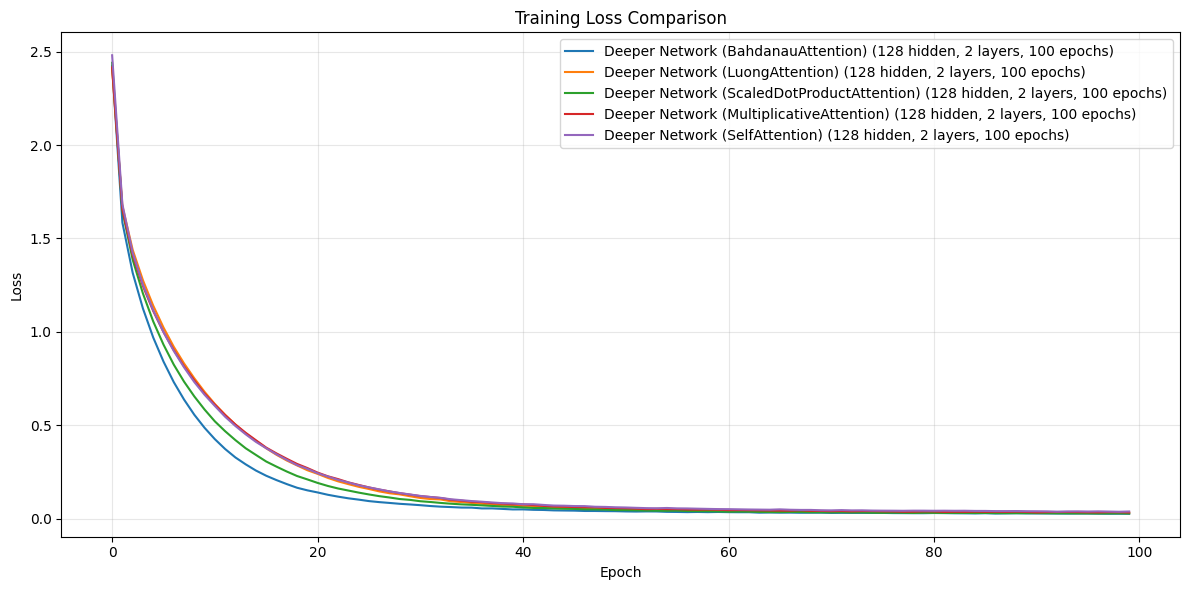

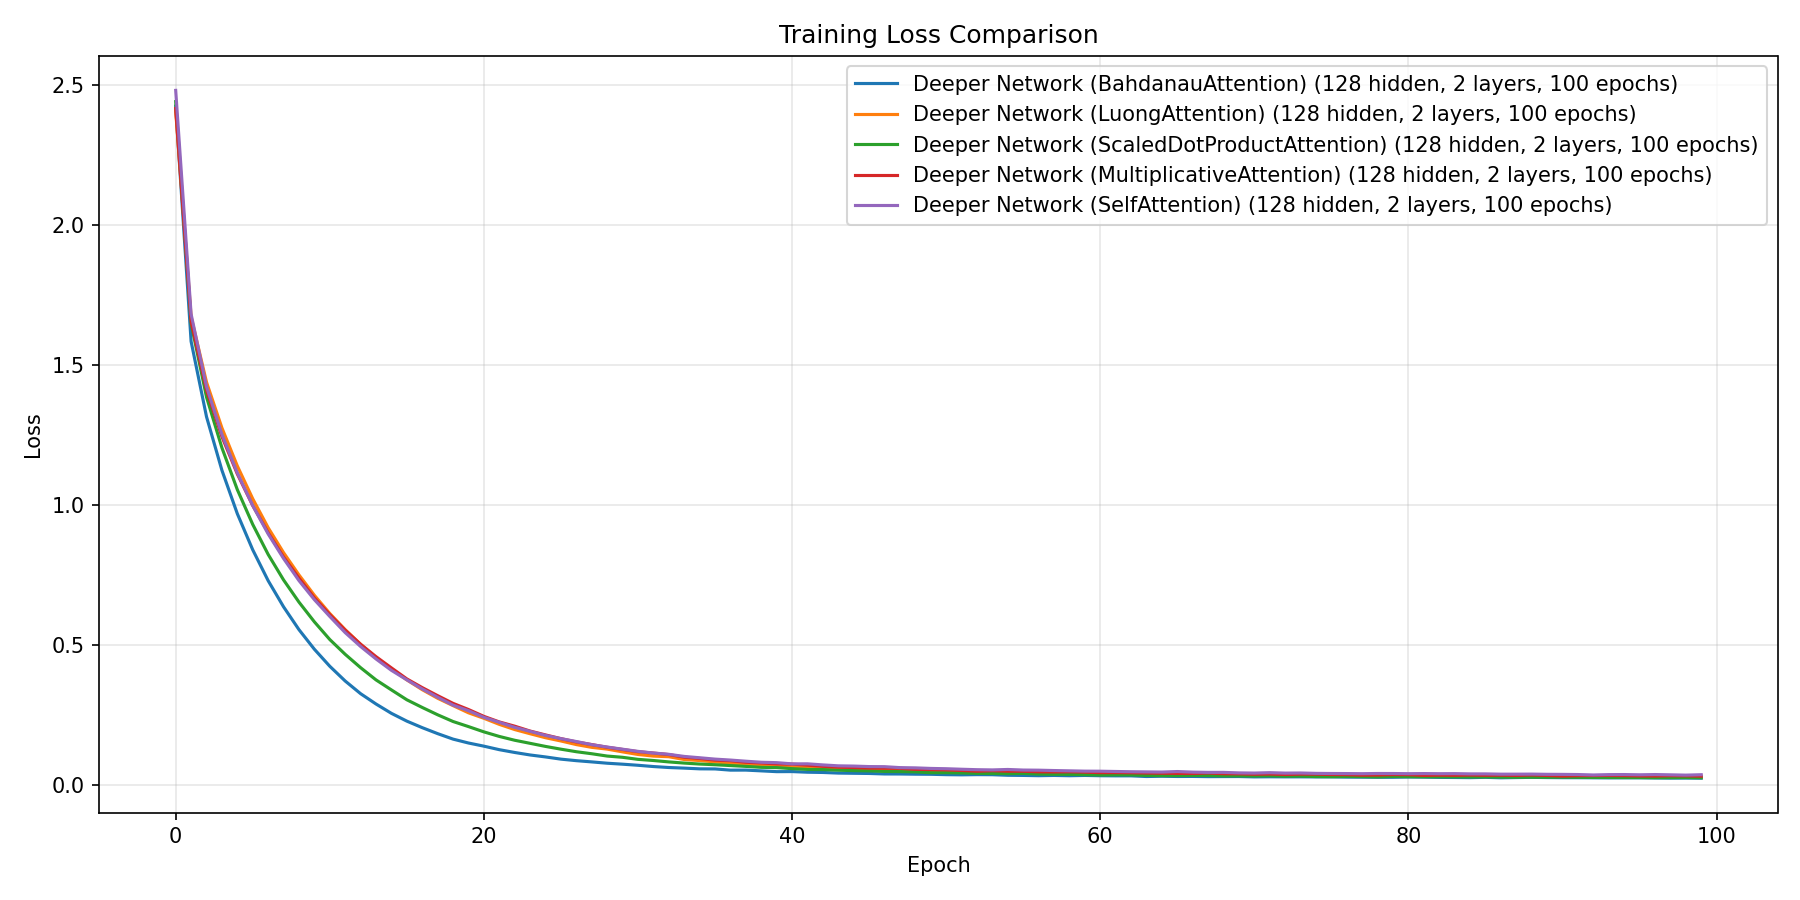

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(losses1, label='Deeper Network (BahdanauAttention) (128 hidden, 2 layers, 100 epochs)')
plt.plot(losses2, label='Deeper Network (LuongAttention) (128 hidden, 2 layers, 100 epochs)')
plt.plot(losses3, label='Deeper Network (ScaledDotProductAttention) (128 hidden, 2 layers, 100 epochs)')
plt.plot(losses4, label='Deeper Network (MultiplicativeAttention) (128 hidden, 2 layers, 100 epochs)')
plt.plot(losses5, label='Deeper Network (SelfAttention) (128 hidden, 2 layers, 100 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison(2).png', dpi=150)
plt.show()
display(Image(filename='comparison(2).png'))

### Промежуточные результаты по выбору наиболее точной модели

| Модель | Итоговый loss | BLEU | BLEU2 | ROUGE-1 | METEOR | chrF | BERTScore | TER
|--|--|--|--|--|--|--|--|--|
|Deeper Network (BahdanauAttention)|0.0468|0.539795|0.491695|0.695149|0.751481|68.981839|0.911601|51.878354|
|Deeper Network (LuongAttention)|0.0581|0.555705|0.464028|0.685902|0.772530|63.665315|0.914487|50.452080|
|Deeper Network (ScaledDotProductAttention)|0.0458|0.657518|0.540979|0.739008|0.770384|73.183730|0.911637|46.462715|
|Deeper Network (MultiplicativeAttention)|0.0634|0.738194|0.626124|0.809912|0.839349|83.750222|0.919711|31.309298|
|Deeper Network (SelfAttention)|0.0465|0.566241|0.503520|0.726248|0.814401|77.050895|0.908318|53.606238|

### Результаты перевода моделей с разными механизмами внимания

|Модель|Оригинал 1|Перевод 1|Ориг.перевод 1|Оригинал 2|Перевод 2|Ориг.перевод 2|Оригинал 3|Перевод 3|Ориг.перевод 3|
|--|--|--|--|--|--|--|--|--|--|
|Deeper Network (BahdanauAttention)|je suis trop fatigue|i m too tired to argue|I'm too tired|il est tres grand|he is very her husband|he is very tall|elle est belle|she is kind to me|she is beautiful|
|Deeper Network (LuongAttention)|je suis trop fatigue|i m too tired to think i am i am|I'm too tired|il est tres grand|he is very tall but no singer|he is very tall|elle est belle|she is beautiful up happy|she is beautiful|
|Deeper Network (ScaledDotProductAttention)|je suis trop fatigue|i am too tired to think|I'm too tired|il est tres grand|he s very tall|he is very tall|elle est belle|she s no friend|she is beautiful|
|Deeper Network (MultiplicativeAttention)|je suis trop fatigue|i am too tired to swim|I'm too tired|il est tres grand|he is very tall|he is very tall|elle est belle|she s doctor to depressed|she is beautiful|
|Deeper Network (SelfAttention)|je suis trop fatigue|i am too tired to walk any longer|I'm too tired|il est tres grand|he is very tall as her|he is very tall|elle est belle|she s a nervous person|she is beautiful|

#### Результаты перевода по сравнению с предыдущим исследованием стали хуже. ***Наилучшие результаты*** по совпадению перевода с оригинальным переводом: у моделей с использованием ScaledDotProductAttention (2 из 3-х совпадений).

### ***Результаты***: наименьший итоговый loss достигается моделью RNN с механизмом внимания ScaledDotProductAttention, наибольший - у этой же модели с механизмом MultiplicativeAttention. Наибольшая точность по метрике BLEU достигается моделью RNN с механизмом внимания MultiplicativeAttention, наименьшая - у модели с механизмом внимания Bahdanau. Наибольшая точность по метрике ROUGE-1 достигается моделью с механизмом внимания ScaledDotProductAttention, наименьшая - у модели с LuongAttention. Наибольшая точность по метрике METEOR достигается моделью с механизмом внимания MultiplicativeAttention, наименьшая - у модели с BahdanauAttention. По метрикам chrF, BERTScore, TER наилучший результат показала модель RNN с MultiplicativeAttention, а наихудший - с SelfAttention. Точность моделей, ранее более устойчивых на одном слое, ухудшилась по сравнению с аутсайдерами при переходе на 2-х слойную модель.

### ***Общие результаты*** по точности моделей:
1. RNN with MultiplicativeAttention.
2. RNN with ScaledDotProductAttention.
3. RNN with SelfAttention.
4. RNN with LuongAttention.
5. RNN with BahdanauAttention.


### ***Вывод***: наиболее совместимыми с оригинальной двухслойной RNN моделью являются механизмы внимания Multiplicative и ScaledDotProduct, наименее совместимыми - Luong и Bahdanau.

## Experiment 3: Оригинальная EncoderRNN модель с использованием AttnDecoder, 256 скрытыми слоями и разными механизмами внимания

In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 11: Larger Hidden Size (256)")
print("="*70)

encoder11 = EncoderRNN(input_lang.n_words, 256).to(device)
decoder11 = AttnDecoderRNN_1(256, output_lang.n_words).to(device)

losses11 = train(train_dataloader, encoder11, decoder11, 100, learning_rate=0.001, print_every=10)

encoder11.eval()
decoder11.eval()

print("\nTest Results (Larger Hidden):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder11, decoder11, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 11: Larger Hidden Size (256)
Epoch 10/100 (10%) - Loss: 0.1098 - Time: 89s
Epoch 20/100 (20%) - Loss: 0.0441 - Time: 175s
Epoch 30/100 (30%) - Loss: 0.0351 - Time: 261s
Epoch 40/100 (40%) - Loss: 0.0307 - Time: 349s
Epoch 50/100 (50%) - Loss: 0.0297 - Time: 438s
Epoch 60/100 (60%) - Loss: 0.0287 - Time: 526s
Epoch 70/100 (70%) - Loss: 0.0264 - Time: 615s
Epoch 80/100 (80%) - Loss: 0.0274 - Time: 707s
Epoch 90/100 (90%) - Loss: 0.0250 - Time: 799s
Epoch 100/100 (100%) - Loss: 0.0261 - Time: 887s

Test Results (Larger Hidden):
  je suis trop fatigue -> i am too tired <EOS>
  il est tres grand -> he is very tall than tall <EOS>
  elle est belle -> she is beautiful to her <EOS>


#### TEST 11: Result loss: 0.0261, Time: 887s.

### Large RNN Encoder (with Bahdanau - 256 hidden layers) - Metrics

In [ ]:
import pandas as pd
bleu11, rouge11 = evaluate_metrics(encoder11, decoder11, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNLarge_Bahdanau = {
    'BLEU': evaluate_bleu(encoder11, decoder11, pairs, input_lang, output_lang),
    'BLEU2': bleu11,
    'ROUGE-1': rouge11,
    'METEOR': evaluate_meteor(encoder11, decoder11, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder11, decoder11, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder11, decoder11, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder11, decoder11, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNLarge_Bahdanau = pd.DataFrame.from_dict(metrics_encoderRNNLarge_Bahdanau, orient='index', columns=['Score'])
print(df_metrics_encoderRNNLarge_Bahdanau)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 417.01 sentences/sec
               Score
BLEU        0.878420
BLEU2       0.737962
ROUGE-1     0.873864
METEOR      0.945041
chrF       91.875845
BERTScore   0.935546
TER        22.490706


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 12: Larger Hidden Size (256)")
print("="*70)

encoder12 = EncoderRNN(input_lang.n_words, 256).to(device)
decoder12 = AttnDecoderRNN_2(256, output_lang.n_words).to(device)

losses12 = train(train_dataloader, encoder12, decoder12, 100, learning_rate=0.001, print_every=10)

encoder12.eval()
decoder12.eval()

print("\nTest Results (Larger Hidden):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder12, decoder12, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 12: Larger Hidden Size (256)
Epoch 10/100 (10%) - Loss: 0.1707 - Time: 76s
Epoch 20/100 (20%) - Loss: 0.0504 - Time: 151s
Epoch 30/100 (30%) - Loss: 0.0378 - Time: 224s
Epoch 40/100 (40%) - Loss: 0.0325 - Time: 297s
Epoch 50/100 (50%) - Loss: 0.0321 - Time: 370s
Epoch 60/100 (60%) - Loss: 0.0298 - Time: 444s
Epoch 70/100 (70%) - Loss: 0.0299 - Time: 517s
Epoch 80/100 (80%) - Loss: 0.0294 - Time: 590s
Epoch 90/100 (90%) - Loss: 0.0294 - Time: 663s
Epoch 100/100 (100%) - Loss: 0.0287 - Time: 736s

Test Results (Larger Hidden):
  je suis trop fatigue -> i am too tired <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she is beautiful beautiful <EOS>


#### TEST 12: Result loss: 0.0287, Time: 736s.

### Large RNN Encoder (with LuongAttention - 256 hidden layers) - Metrics

In [ ]:
bleu12, rouge12 = evaluate_metrics(encoder12, decoder12, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNLarge_LuongAttention = {
    'BLEU': evaluate_bleu(encoder12, decoder12, pairs, input_lang, output_lang),
    'BLEU2': bleu12,
    'ROUGE-1': rouge12,
    'METEOR': evaluate_meteor(encoder12, decoder12, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder12, decoder12, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder12, decoder12, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder12, decoder12, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNLarge_LuongAttention = pd.DataFrame.from_dict(metrics_encoderRNNLarge_LuongAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNLarge_LuongAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.23 seconds, 431.82 sentences/sec
               Score
BLEU        0.818799
BLEU2       0.670500
ROUGE-1     0.847017
METEOR      0.952196
chrF       89.497763
BERTScore   0.928484
TER        26.653696


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 13: Larger Hidden Size (256)")
print("="*70)

encoder13 = EncoderRNN(input_lang.n_words, 256).to(device)
decoder13 = AttnDecoderRNN_3(256, output_lang.n_words).to(device)

losses13 = train(train_dataloader, encoder13, decoder13, 100, learning_rate=0.001, print_every=10)

encoder13.eval()
decoder13.eval()

print("\nTest Results (Larger Hidden):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder13, decoder13, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 13: Larger Hidden Size (256)
Epoch 10/100 (10%) - Loss: 0.1410 - Time: 69s
Epoch 20/100 (20%) - Loss: 0.0485 - Time: 138s
Epoch 30/100 (30%) - Loss: 0.0358 - Time: 207s
Epoch 40/100 (40%) - Loss: 0.0338 - Time: 276s
Epoch 50/100 (50%) - Loss: 0.0303 - Time: 345s
Epoch 60/100 (60%) - Loss: 0.0290 - Time: 415s
Epoch 70/100 (70%) - Loss: 0.0289 - Time: 483s
Epoch 80/100 (80%) - Loss: 0.0266 - Time: 552s
Epoch 90/100 (90%) - Loss: 0.0261 - Time: 622s
Epoch 100/100 (100%) - Loss: 0.0260 - Time: 691s

Test Results (Larger Hidden):
  je suis trop fatigue -> i am too tired and tired too tired <EOS>
  il est tres grand -> he is very tall in great <EOS>
  elle est belle -> she is as beautiful as her <EOS>


#### TEST 13: Result loss: 0.0260, Time: 691s.

### Large RNN Encoder (with ScaledDotProductAttention - 256 hidden layers) - Metrics

In [ ]:
bleu13, rouge13 = evaluate_metrics(encoder13, decoder13, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNLarge_ScaledDotProductAttention = {
    'BLEU': evaluate_bleu(encoder13, decoder13, pairs, input_lang, output_lang),
    'BLEU2': bleu13,
    'ROUGE-1': rouge13,
    'METEOR': evaluate_meteor(encoder13, decoder13, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder13, decoder13, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder13, decoder13, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder13, decoder13, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNLarge_ScaledDotProductAttention = pd.DataFrame.from_dict(metrics_encoderRNNLarge_ScaledDotProductAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNLarge_ScaledDotProductAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.23 seconds, 437.58 sentences/sec
               Score
BLEU        0.709355
BLEU2       0.604781
ROUGE-1     0.818036
METEOR      0.913954
chrF       88.606261
BERTScore   0.919645
TER        31.660232


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 14: Larger Hidden Size (256)")
print("="*70)

encoder14 = EncoderRNN(input_lang.n_words, 256).to(device)
decoder14 = AttnDecoderRNN_4(256, output_lang.n_words).to(device)

losses14 = train(train_dataloader, encoder14, decoder14, 100, learning_rate=0.001, print_every=10)

encoder14.eval()
decoder14.eval()

print("\nTest Results (Larger Hidden):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder14, decoder14, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 14: Larger Hidden Size (256)
Epoch 10/100 (10%) - Loss: 0.1507 - Time: 75s
Epoch 20/100 (20%) - Loss: 0.0507 - Time: 149s
Epoch 30/100 (30%) - Loss: 0.0389 - Time: 223s
Epoch 40/100 (40%) - Loss: 0.0327 - Time: 298s
Epoch 50/100 (50%) - Loss: 0.0315 - Time: 372s
Epoch 60/100 (60%) - Loss: 0.0308 - Time: 447s
Epoch 70/100 (70%) - Loss: 0.0295 - Time: 522s
Epoch 80/100 (80%) - Loss: 0.0289 - Time: 598s
Epoch 90/100 (90%) - Loss: 0.0280 - Time: 675s
Epoch 100/100 (100%) - Loss: 0.0281 - Time: 751s

Test Results (Larger Hidden):
  je suis trop fatigue -> i am too tired to argue <EOS>
  il est tres grand -> he is very tall in his tall <EOS>
  elle est belle -> she is beautiful like beautiful <EOS>


#### TEST 14: Result loss: 0.0281, Time: 751s.

### Large RNN Encoder (with MultiplicativeAttention - 256 hidden layers) - Metrics

In [ ]:
bleu14, rouge14 = evaluate_metrics(encoder14, decoder14, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNLarge_MultiplicativeAttention = {
    'BLEU': evaluate_bleu(encoder14, decoder14, pairs, input_lang, output_lang),
    'BLEU2': bleu14,
    'ROUGE-1': rouge14,
    'METEOR': evaluate_meteor(encoder14, decoder14, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder14, decoder14, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder14, decoder14, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder14, decoder14, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNLarge_MultiplicativeAttention = pd.DataFrame.from_dict(metrics_encoderRNNLarge_MultiplicativeAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNLarge_MultiplicativeAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 415.66 sentences/sec
               Score
BLEU        0.755893
BLEU2       0.600128
ROUGE-1     0.808859
METEOR      0.907242
chrF       87.037370
BERTScore   0.926084
TER        30.384615


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 15: Larger Hidden Size (256)")
print("="*70)

encoder15 = EncoderRNN(input_lang.n_words, 256).to(device)
decoder15 = AttnDecoderRNN_5(256, output_lang.n_words).to(device)

losses15 = train(train_dataloader, encoder15, decoder15, 100, learning_rate=0.001, print_every=10)

encoder15.eval()
decoder15.eval()

print("\nTest Results (Larger Hidden):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder15, decoder15, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 15: Larger Hidden Size (256)
Epoch 10/100 (10%) - Loss: 0.1977 - Time: 101s
Epoch 20/100 (20%) - Loss: 0.0628 - Time: 203s
Epoch 30/100 (30%) - Loss: 0.0489 - Time: 307s
Epoch 40/100 (40%) - Loss: 0.0446 - Time: 412s
Epoch 50/100 (50%) - Loss: 0.0429 - Time: 516s
Epoch 60/100 (60%) - Loss: 0.0399 - Time: 622s
Epoch 70/100 (70%) - Loss: 0.0399 - Time: 726s
Epoch 80/100 (80%) - Loss: 0.0416 - Time: 832s
Epoch 90/100 (90%) - Loss: 0.0405 - Time: 934s
Epoch 100/100 (100%) - Loss: 0.0399 - Time: 1034s

Test Results (Larger Hidden):
  je suis trop fatigue -> i am tired neither too tired <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she s rich beautiful than a novelist <EOS>


#### TEST 15: Result loss: 0.0399, Time: 1034s.

### Large RNN Encoder (with SelfAttention - 256 hidden layers) - Metrics

In [ ]:
bleu15, rouge15 = evaluate_metrics(encoder15, decoder15, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNLarge_SelfAttention = {
    'BLEU': evaluate_bleu(encoder15, decoder15, pairs, input_lang, output_lang),
    'BLEU2': bleu15,
    'ROUGE-1': rouge15,
    'METEOR': evaluate_meteor(encoder15, decoder15, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder15, decoder15, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder15, decoder15, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder15, decoder15, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNLarge_SelfAttention = pd.DataFrame.from_dict(metrics_encoderRNNLarge_SelfAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNLarge_SelfAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 411.12 sentences/sec
               Score
BLEU        0.788738
BLEU2       0.622224
ROUGE-1     0.815012
METEOR      0.909739
chrF       88.366145
BERTScore   0.930146
TER        29.766537


### Сравнение Large RNN моделей с разными механизмами внимания

In [ ]:
# ===============================
# COMPARISON
# ===============================

print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

print("\nFinal Losses:")
print(f"  Large Hidden (BahdanauAttention):     {losses11[-1]:.4f}")
print(f"  Large Hidden (LuongAttention): {losses12[-1]:.4f}")
print(f"  Large Hidden (ScaledDotProductAttention): {losses13[-1]:.4f}")
print(f"  Large Hidden (MultiplicativeAttention):  {losses14[-1]:.4f}")
print(f"  Large Hidden (SelfAttention):  {losses15[-1]:.4f}")



RESULTS COMPARISON

Final Losses:
  Large Hidden (BahdanauAttention):     0.0261
  Large Hidden (LuongAttention): 0.0287
  Large Hidden (ScaledDotProductAttention): 0.0260
  Large Hidden (MultiplicativeAttention):  0.0281
  Large Hidden (SelfAttention):  0.0399


### График loss-функции LargeRNN моделей с разными механизмами внимания

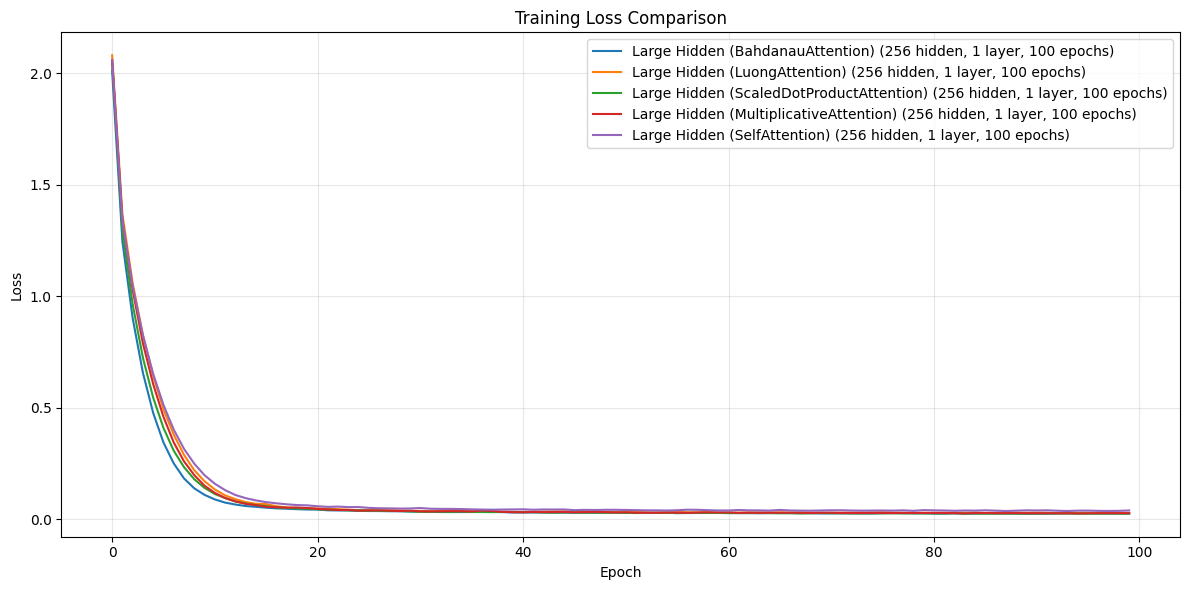

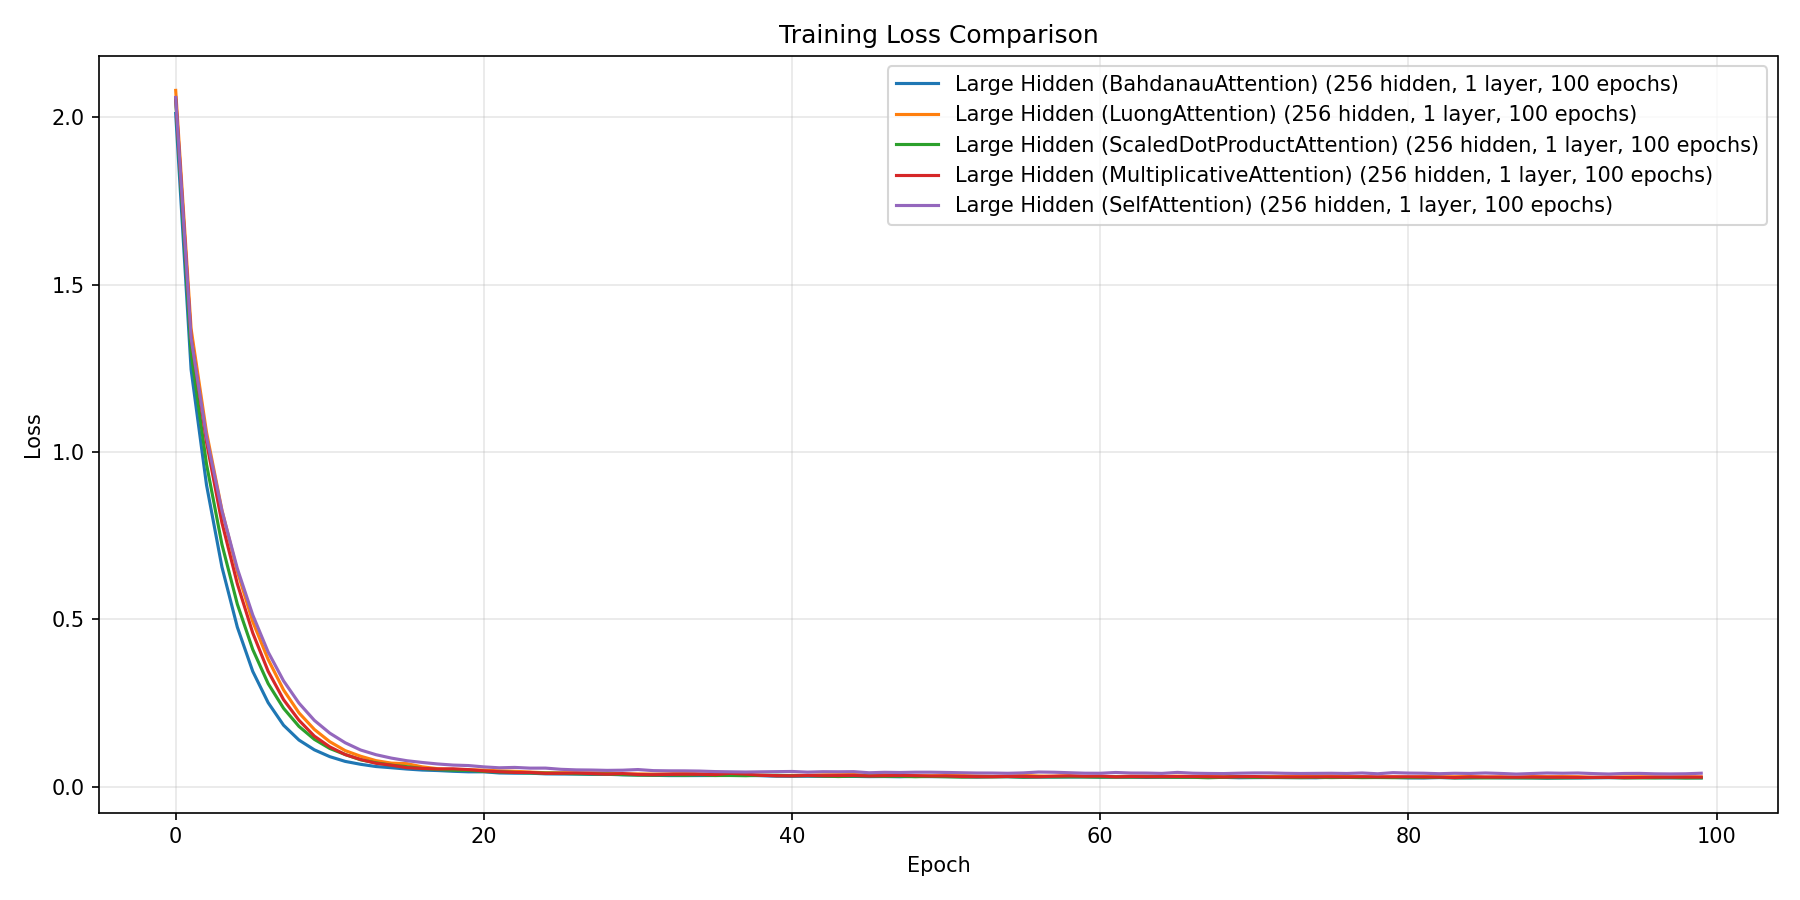

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

plt.figure(figsize=(12, 6))
plt.plot(losses11, label='Large Hidden (BahdanauAttention) (256 hidden, 1 layer, 100 epochs)')
plt.plot(losses12, label='Large Hidden (LuongAttention) (256 hidden, 1 layer, 100 epochs)')
plt.plot(losses13, label='Large Hidden (ScaledDotProductAttention) (256 hidden, 1 layer, 100 epochs)')
plt.plot(losses14, label='Large Hidden (MultiplicativeAttention) (256 hidden, 1 layer, 100 epochs)')
plt.plot(losses15, label='Large Hidden (SelfAttention) (256 hidden, 1 layer, 100 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison(3).png', dpi=150)
plt.show()
display(Image(filename='comparison(3).png'))

### Промежуточные результаты по выбору наиболее точной модели

| Модель | Итоговый loss | BLEU | BLEU2 | ROUGE-1 | METEOR | chrF | BERTScore | TER
|--|--|--|--|--|--|--|--|--|
|Large Hidden (BahdanauAttention)|0.0261|0.878420|0.737962|0.873864|0.945041|91.875845|0.935546|22.490706|
|Large Hidden (LuongAttention)|0.0287|0.818799|0.670500|0.847017|0.952196|89.497763|0.928484|26.653696|
|Large Hidden (ScaledDotProductAttention)|0.0260|0.709355|0.604781|0.818036|0.913954|88.606261|0.919645|31.660232|
|Large Hidden (MultiplicativeAttention)|0.0281|0.755893|0.600128|0.808859|0.907242|87.037370|0.926084|30.384615|
|Large Hidden (SelfAttention)|0.0399|0.788738|0.622224|0.815012|0.909739|88.366145|0.930146|29.766537|

### Результаты перевода моделей с разными механизмами внимания

|Модель|Оригинал 1|Перевод 1|Ориг.перевод 1|Оригинал 2|Перевод 2|Ориг.перевод 2|Оригинал 3|Перевод 3|Ориг.перевод 3|
|--|--|--|--|--|--|--|--|--|--|
|Large Hidden (BahdanauAttention)|je suis trop fatigue|i am too tired|I'm too tired|il est tres grand|he is very tall than tall|he is very tall|elle est belle|she is beautiful to her|she is beautiful|
|Large Hidden (LuongAttention)|je suis trop fatigue|i am too tired|I'm too tired|il est tres grand|he is very tall|he is very tall|elle est belle|she is beautiful beautiful|she is beautiful|
|Large Hidden (ScaledDotProductAttention)|je suis trop fatigue|i am too tired and tired too tired|I'm too tired|il est tres grand|he is very tall in great|he is very tall|elle est belle|she is as beautiful as her|she is beautiful|
|Large Hidden (MultiplicativeAttention)|je suis trop fatigue|i am too tired to argue|I'm too tired|il est tres grand|he is very tall in his tall|he is very tall|elle est belle|she is beautiful like beautiful|she is beautiful|
|Large Hidden (SelfAttention)|je suis trop fatigue|i am tired neither too tired|I'm too tired|il est tres grand|he is very tall|he is very tall|elle est belle|she s rich beautiful than a novelist|she is beautiful|

#### ***Результаты*** перевода по сравнению с предыдущим исследованием стали лучiе. Наилучшие результаты по совпадению перевода с оригинальным переводом: у моделей с использованием LuongAttention и BahdanauAttention.

### ***Результаты***: наименьший итоговый loss достигается моделью RNN с механизмом внимания ScaledDotProductAttention, наибольший - у этой же модели с механизмом SelfAttention. Наибольшая точность по метрике BLEU достигается моделью RNN с механизмом внимания BahdanauAttention, наименьшая - у модели с механизмом внимания ScaledDotProduct. Наибольшая точность по метрике ROUGE-1 достигается моделью с механизмом внимания BahdanauAttention, наименьшая - у модели с MultiplicativeAttention. Наибольшая точность по метрике METEOR достигается моделью с механизмом внимания LuongAttention, наименьшая - у модели с MultiplicativeAttention. По метрикам chrF, BERTScore, TER наилучший результат показала модель RNN с BahdanauAttention, а наихудший - с ScaledDotProduct. Количество скрытых слоев меньше влияет на результаты моделей по сравнению с изменением явных числов слоев рекурентной RNN модели.

### ***Общие результаты*** по точности моделей:
1. RNN with BahdanauAttention.
2. RNN with LuongAttention.
3. RNN with SelfAttention.
4. RNN with MultiplicativeAttention.
5. RNN with ScaledDotProduct.

### ***Вывод***: наиболее совместимыми с оригинальной RNN моделью с 256 скрытыми слоями являются механизмы внимания Bahdanau и Luong, наименее совместимыми - ScaledDotProduct и Multiplicative.

## Experiment 4: Оригинальная EncoderRNN модель с использованием AttnDecoder, 128 скрытыми слоями и разными механизмами внимания на более малом числе эпох (50)

In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 16: Less Training Epochs (50)")
print("="*70)

encoder16 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder16 = AttnDecoderRNN_1(128, output_lang.n_words).to(device)

losses16 = train(train_dataloader, encoder16, decoder16, 50, learning_rate=0.001, print_every=10)

encoder16.eval()
decoder16.eval()

print("\nTest Results (More Epochs):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder16, decoder16, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 16: Less Training Epochs (50)
Epoch 10/50 (20%) - Loss: 0.4941 - Time: 89s
Epoch 20/50 (40%) - Loss: 0.1450 - Time: 178s
Epoch 30/50 (60%) - Loss: 0.0681 - Time: 266s
Epoch 40/50 (80%) - Loss: 0.0465 - Time: 353s
Epoch 50/50 (100%) - Loss: 0.0389 - Time: 442s

Test Results (More Epochs):
  je suis trop fatigue -> i am too tired too <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she is beautiful beautiful <EOS>


#### TEST 16: Result loss: 0.0389, Time: 442s.

### Small RNN Encoder (with BahdanauAttention - 50 epochs) - Metrics

In [ ]:
bleu16, rouge16 = evaluate_metrics(encoder16, decoder16, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNSmall_Bahdanau = {
    'BLEU': evaluate_bleu(encoder16, decoder16, pairs, input_lang, output_lang),
    'BLEU2': bleu16,
    'ROUGE-1': rouge16,
    'METEOR': evaluate_meteor(encoder16, decoder16, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder16, decoder16, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder16, decoder16, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder16, decoder16, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNSmall_Bahdanau = pd.DataFrame.from_dict(metrics_encoderRNNSmall_Bahdanau, orient='index', columns=['Score'])
print(df_metrics_encoderRNNSmall_Bahdanau)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.22 seconds, 448.26 sentences/sec
               Score
BLEU        0.791988
BLEU2       0.648965
ROUGE-1     0.841389
METEOR      0.929620
chrF       90.343784
BERTScore   0.927344
TER        27.766990


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 17: Less Training Epochs (50)")
print("="*70)

encoder17 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder17 = AttnDecoderRNN_2(128, output_lang.n_words).to(device)

losses17 = train(train_dataloader, encoder17, decoder17, 50, learning_rate=0.001, print_every=10)

encoder17.eval()
decoder17.eval()

print("\nTest Results (More Epochs):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder17, decoder17, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 17: Less Training Epochs (50)
Epoch 10/50 (20%) - Loss: 0.6863 - Time: 71s
Epoch 20/50 (40%) - Loss: 0.2693 - Time: 141s
Epoch 30/50 (60%) - Loss: 0.1232 - Time: 212s
Epoch 40/50 (80%) - Loss: 0.0730 - Time: 283s
Epoch 50/50 (100%) - Loss: 0.0544 - Time: 354s

Test Results (More Epochs):
  je suis trop fatigue -> i m too tired to close about anything about the
  il est tres grand -> he is very tall but the very tall <EOS>
  elle est belle -> she s as beautiful but beautiful woman she <EOS>


#### TEST 17: Result loss: 0.0544, Time: 354s.

### Small RNN Encoder (with LuongAttention - 50 epochs) - Metrics

In [ ]:
bleu17, rouge17 = evaluate_metrics(encoder17, decoder17, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNSmall_LuongAttention = {
    'BLEU': evaluate_bleu(encoder17, decoder17, pairs, input_lang, output_lang),
    'BLEU2': bleu17,
    'ROUGE-1': rouge17,
    'METEOR': evaluate_meteor(encoder17, decoder17, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder17, decoder17, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder17, decoder17, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder17, decoder17, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNSmall_LuongAttention = pd.DataFrame.from_dict(metrics_encoderRNNSmall_LuongAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNSmall_LuongAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.24 seconds, 409.09 sentences/sec
               Score
BLEU        0.482024
BLEU2       0.475502
ROUGE-1     0.693782
METEOR      0.759882
chrF       72.045883
BERTScore   0.905203
TER        63.483146


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 18: Less Training Epochs (50)")
print("="*70)

encoder18 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder18 = AttnDecoderRNN_3(128, output_lang.n_words).to(device)

losses18 = train(train_dataloader, encoder18, decoder18, 50, learning_rate=0.001, print_every=10)

encoder18.eval()
decoder18.eval()

print("\nTest Results (More Epochs):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder18, decoder18, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 18: Less Training Epochs (50)
Epoch 10/50 (20%) - Loss: 0.6191 - Time: 68s
Epoch 20/50 (40%) - Loss: 0.2190 - Time: 134s
Epoch 30/50 (60%) - Loss: 0.0980 - Time: 201s
Epoch 40/50 (80%) - Loss: 0.0588 - Time: 272s
Epoch 50/50 (100%) - Loss: 0.0433 - Time: 341s

Test Results (More Epochs):
  je suis trop fatigue -> i m too tired <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she is poor beauty <EOS>


#### TEST 18: Result loss: 0.0433, Time: 341s.

### Small RNN Encoder (with ScaledDotProductAttention - 50 epochs) - Metrics

In [ ]:
bleu18, rouge18 = evaluate_metrics(encoder18, decoder18, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNSmall_ScaledDotProductAttention = {
    'BLEU': evaluate_bleu(encoder18, decoder18, pairs, input_lang, output_lang),
    'BLEU2': bleu18,
    'ROUGE-1': rouge18,
    'METEOR': evaluate_meteor(encoder18, decoder18, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder18, decoder18, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder18, decoder18, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder18, decoder18, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNSmall_ScaledDotProductAttention = pd.DataFrame.from_dict(metrics_encoderRNNSmall_ScaledDotProductAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNSmall_ScaledDotProductAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.23 seconds, 428.59 sentences/sec
               Score
BLEU        0.748032
BLEU2       0.675706
ROUGE-1     0.843739
METEOR      0.899025
chrF       87.883908
BERTScore   0.924510
TER        38.086304


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 19: Less Training Epochs (50)")
print("="*70)

encoder19 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder19 = AttnDecoderRNN_4(128, output_lang.n_words).to(device)

losses19 = train(train_dataloader, encoder19, decoder19, 50, learning_rate=0.001, print_every=10)

encoder19.eval()
decoder19.eval()

print("\nTest Results (More Epochs):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder19, decoder19, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 19: Less Training Epochs (50)
Epoch 10/50 (20%) - Loss: 0.6461 - Time: 76s
Epoch 20/50 (40%) - Loss: 0.2516 - Time: 150s
Epoch 30/50 (60%) - Loss: 0.1209 - Time: 222s
Epoch 40/50 (80%) - Loss: 0.0740 - Time: 294s
Epoch 50/50 (100%) - Loss: 0.0578 - Time: 366s

Test Results (More Epochs):
  je suis trop fatigue -> i am tired too tired of tired <EOS>
  il est tres grand -> he is very tall tall <EOS>
  elle est belle -> she is beautiful beautiful beautiful than her <EOS>


#### TEST 19: Result loss: 0.0578, Time: 366s.

### Small RNN Encoder (with MultiplicativeAttention - 50 epochs) - Metrics

In [ ]:
bleu19, rouge19 = evaluate_metrics(encoder19, decoder19, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNSmall_MultiplicativeAttention = {
    'BLEU': evaluate_bleu(encoder19, decoder19, pairs, input_lang, output_lang),
    'BLEU2': bleu19,
    'ROUGE-1': rouge19,
    'METEOR': evaluate_meteor(encoder19, decoder19, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder19, decoder19, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder19, decoder19, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder19, decoder19, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNSmall_MultiplicativeAttention = pd.DataFrame.from_dict(metrics_encoderRNNSmall_MultiplicativeAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNSmall_MultiplicativeAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.23 seconds, 432.07 sentences/sec
               Score
BLEU        0.566571
BLEU2       0.553973
ROUGE-1     0.737829
METEOR      0.773466
chrF       74.938048
BERTScore   0.911434
TER        56.250000


In [ ]:
print("\n" + "="*70)
print("EXPERIMENT 20: Less Training Epochs (50)")
print("="*70)

encoder20 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder20 = AttnDecoderRNN_5(128, output_lang.n_words).to(device)

losses20 = train(train_dataloader, encoder20, decoder20, 50, learning_rate=0.001, print_every=10)

encoder20.eval()
decoder20.eval()

print("\nTest Results (More Epochs):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder20, decoder20, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 20: Less Training Epochs (50)
Epoch 10/50 (20%) - Loss: 0.6745 - Time: 97s
Epoch 20/50 (40%) - Loss: 0.2671 - Time: 195s
Epoch 30/50 (60%) - Loss: 0.1273 - Time: 294s
Epoch 40/50 (80%) - Loss: 0.0776 - Time: 393s
Epoch 50/50 (100%) - Loss: 0.0591 - Time: 491s

Test Results (More Epochs):
  je suis trop fatigue -> i am too tired to do <EOS>
  il est tres grand -> he is very tall and very <EOS>
  elle est belle -> she s beautiful than beautiful sister <EOS>


#### TEST 20: Result loss: 0.0591, Time: 491s.

### Small RNN Encoder (with SelfAttention - 50 epochs) - Metrics

In [ ]:
bleu20, rouge20 = evaluate_metrics(encoder20, decoder20, pairs, input_lang, output_lang, n=100)
metrics_encoderRNNSmall_SelfAttention = {
    'BLEU': evaluate_bleu(encoder20, decoder20, pairs, input_lang, output_lang),
    'BLEU2': bleu20,
    'ROUGE-1': rouge20,
    'METEOR': evaluate_meteor(encoder20, decoder20, pairs, input_lang, output_lang),
    'chrF': evaluate_chrf(encoder20, decoder20, pairs, input_lang, output_lang),
    'BERTScore': evaluate_bertscore(encoder20, decoder20, pairs, input_lang, output_lang, lang='en'),
    'TER': evaluate_ter(encoder20, decoder20, pairs, input_lang, output_lang)
}
df_metrics_encoderRNNSmall_SelfAttention = pd.DataFrame.from_dict(metrics_encoderRNNSmall_SelfAttention, orient='index', columns=['Score'])
print(df_metrics_encoderRNNSmall_SelfAttention)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.23 seconds, 426.07 sentences/sec
               Score
BLEU        0.534013
BLEU2       0.516076
ROUGE-1     0.729015
METEOR      0.797702
chrF       80.630038
BERTScore   0.915834
TER        49.709865


In [ ]:
# ===============================
# COMPARISON
# ===============================

print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

print("\nFinal Losses:")
print(f"  Small Size (BahdanauAttention):     {losses16[-1]:.4f}")
print(f"  Small Size (LuongAttention): {losses17[-1]:.4f}")
print(f"  Small Size (ScaledDotProductAttention): {losses18[-1]:.4f}")
print(f"  Small Size (MultiplicativeAttention):  {losses19[-1]:.4f}")
print(f"  Small Size (SelfAttention):  {losses20[-1]:.4f}")



RESULTS COMPARISON

Final Losses:
  Small Size (BahdanauAttention):     0.0389
  Small Size (LuongAttention): 0.0544
  Small Size (ScaledDotProductAttention): 0.0433
  Small Size (MultiplicativeAttention):  0.0578
  Small Size (SelfAttention):  0.0591


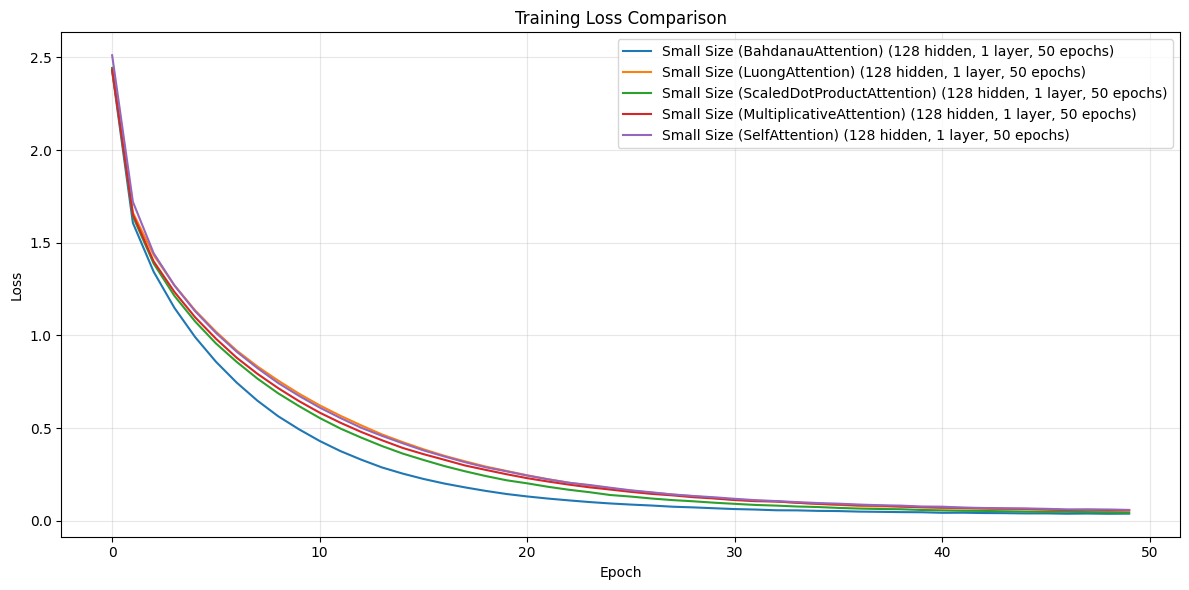

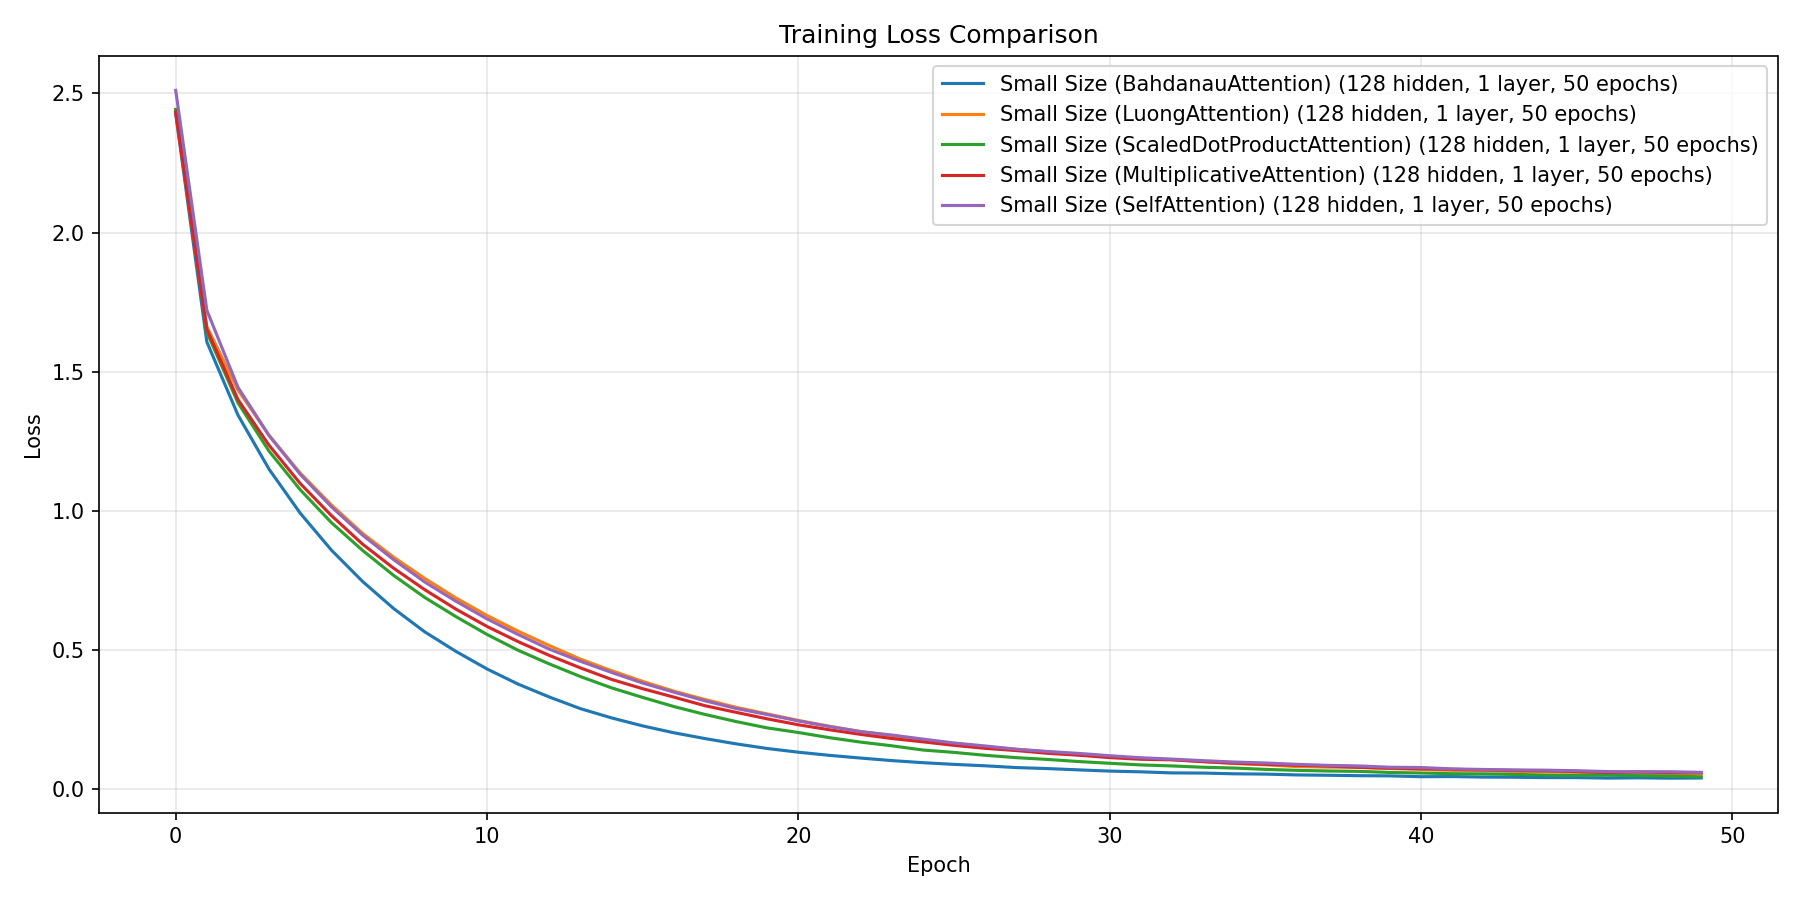

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(losses16, label='Small Size (BahdanauAttention) (128 hidden, 1 layer, 50 epochs)')
plt.plot(losses17, label='Small Size (LuongAttention) (128 hidden, 1 layer, 50 epochs)')
plt.plot(losses18, label='Small Size (ScaledDotProductAttention) (128 hidden, 1 layer, 50 epochs)')
plt.plot(losses19, label='Small Size (MultiplicativeAttention) (128 hidden, 1 layer, 50 epochs)')
plt.plot(losses20, label='Small Size (SelfAttention) (128 hidden, 1 layer, 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison(4).png', dpi=150)
plt.show()
display(Image(filename='comparison(4).png'))

### Промежуточные результаты по выбору наиболее точной модели

| Модель | Итоговый loss | BLEU | BLEU2 | ROUGE-1 | METEOR | chrF | BERTScore | TER
|--|--|--|--|--|--|--|--|--|
|Small Size (BahdanauAttention)|0.0389|0.791988|0.648965|0.841389|0.929620|90.343784|0.927344|27.766990|
|Small Size (LuongAttention)|0.0544|0.482024|0.475502|0.693782|0.759882|72.045883|0.905203|63.483146|
|Small Size (ScaledDotProductAttention)|0.0433|0.748032|0.675706|0.843739|0.899025|87.883908|0.924510|38.086304|
|Small Size (MultiplicativeAttention)|0.0578|0.566571|0.553973|0.737829|0.773466|74.938048|0.911434|56.250000|
|Small Size (SelfAttention)|0.0591|0.534013|0.516076|0.729015|0.797702|80.630038|0.915834|49.709865|

### Результаты перевода моделей с разными механизмами внимания

|Модель|Оригинал 1|Перевод 1|Ориг.перевод 1|Оригинал 2|Перевод 2|Ориг.перевод 2|Оригинал 3|Перевод 3|Ориг.перевод 3|
|--|--|--|--|--|--|--|--|--|--|
|Small Size (BahdanauAttention)|je suis trop fatigue|i am too tired too|I'm too tired|il est tres grand|he is very tall|he is very tall|elle est belle|she is beautiful beautiful|she is beautiful|
|Small Size (LuongAttention)|je suis trop fatigue|i m too tired to close about anything about the|I'm too tired|il est tres grand|he is very tall but the very tall|he is very tall|elle est belle|she s as beautiful but beautiful woman she|she is beautiful|
|Small Size (ScaledDotProductAttention)|je suis trop fatigue|i m too tired|I'm too tired|il est tres grand|he is very tall|he is very tall|elle est belle|she is poor beauty|she is beautiful|
|Small Size (MultiplicativeAttention)|je suis trop fatigue|i am tired too tired of tired|I'm too tired|il est tres grand|he is very tall tall|he is very tall|elle est belle|she is beautiful beautiful beautiful than her|she is beautiful|
|Small Size (SelfAttention)|je suis trop fatigue|i am too tired to do|I'm too tired|il est tres grand|he is very tall and very|he is very tall|elle est belle|she s beautiful than beautiful sister|she is beautiful|

#### ***Результаты*** перевода по сравнению с предыдущим исследованием стали лучше. Наилучшие результаты по совпадению перевода с оригинальным переводом: у моделей с использованием BahdanauAttention и ScaledDotProductAttention.

### ***Результаты***: наименьший итоговый loss достигается моделью RNN с механизмом внимания BahdanauAttention, наибольший - у этой же модели с механизмом SelfAttention. Наибольшая точность по метрике BLEU достигается моделью RNN с механизмом внимания BahdanauAttention/ScaledDotProduct, наименьшая - у модели с механизмом внимания LuongAttention. Наибольшая точность по метрике ROUGE-1 достигается моделью с механизмом внимания ScaledDotProduct, наименьшая - у модели с LuongAttention. Наибольшая точность по метрике METEOR достигается моделью с механизмом внимания BahdanauAttention, наименьшая - у модели с LuongAttention. По метрикам chrF, BERTScore, TER наилучший результат показала модель RNN с BahdanauAttention, а наихудший - с LuongAttention. Использование меньшего числа эпох влияет на большую часть моделей незначительно, за исключением модели с механизмом внимания LuongAttention.

### ***Общие результаты*** по точности моделей:
1. RNN with BahdanauAttention.
2. RNN with ScaledDotProduct.
3. RNN with SelfAttention.
4. RNN with MultiplicativeAttention.
5. RNN with LuongAttention.

### ***Вывод***: наиболее совместимыми с оригинальной RNN моделью при обучении на меньшем числом эпох (50 против 100 в первом эксперименте) являются механизмы внимания Bahdanau и ScaledDotProduct, наименее совместимыми - LuongAttention и Multiplicative.

## Experiment 5: Оригинальная EncoderRNN модель с использованием полного датасета

In [ ]:
# Experiment 21: More Sentences
print("\n" + "="*70)
print("EXPERIMENT 21: More Sentences")
print("="*70)

input_lang_2, output_lang_2, train_dataloader_2, pairs_2 = get_dataloader_2(32)  # Larger dataset due to relaxed filter

encoder21 = EncoderRNN(input_lang_2.n_words, 128).to(device)
decoder21 = AttnDecoderRNN_1(128, output_lang_2.n_words).to(device)

start_time = time.time()
losses21 = train(train_dataloader_2, encoder21, decoder21, 100, learning_rate=0.001, print_every=10)
training_time = time.time() - start_time

encoder21.eval()
decoder21.eval()

print(f"\nTraining Time: {training_time:.0f} seconds")
print("\nTest Results (More Sentences):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder21, decoder21, sentence, input_lang_2, output_lang_2)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 21: More Sentences
Reading lines...
Read 135842 sentence pairs
Trimmed to 105692 sentence pairs
Counting words...
Counted words:
fra 17864
eng 10698


In [ ]:
bleu21, rouge21 = evaluate_metrics(encoder21, decoder21, pairs, input_lang_2, output_lang_2, n=100)
metrics_encoderRNNSentenses_Bahdanau = {
    'BLEU': evaluate_bleu(encoder21, decoder21, pairs, input_lang_2, output_lang_2),
    'BLEU2': bleu21,
    'ROUGE-1': rouge21,
    'METEOR': evaluate_meteor(encoder21, decoder21, pairs, input_lang_2, output_lang_2),
    'chrF': evaluate_chrf(encoder21, decoder21, pairs, input_lang_2, output_lang_2),
    'BERTScore': evaluate_bertscore(encoder21, decoder21, pairs, input_lang_2, output_lang_2, lang='en'),
    'TER': evaluate_ter(encoder21, decoder21, pairs, input_lang_2, output_lang_2)
}
df_metrics_encoderRNNSentenses_Bahdanau = pd.DataFrame.from_dict(metrics_encoderRNNSentenses_Bahdanau, orient='index', columns=['Score'])
print(df_metrics_encoderRNNSentenses_Bahdanau)

In [ ]:
# Add Word2Vec loading support
from gensim.models import KeyedVectors

def load_word2vec_embeddings(lang: Lang, embedding_file: str, embedding_dim: int = 300) -> Optional[torch.Tensor]:
    try:
        model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
        print(f"Loaded Word2Vec model with {len(model.key_to_index)} vectors")

        embedding_matrix = np.random.randn(lang.n_words, embedding_dim).astype(np.float32) * 0.01
        found = 0
        for word, idx in lang.word2index.items():
            if word in model:
                embedding_matrix[idx] = model[word]
                found += 1

        print(f"Found Word2Vec embeddings for {found}/{lang.n_words} words")
        return torch.from_numpy(embedding_matrix)
    except FileNotFoundError:
        print(f"Word2Vec file not found: {embedding_file}")
        return None

# Update experiment code
print("\n" + "="*70)
print("EXPERIMENT 5: Pretrained GloVe Embeddings")
print("="*70)

# Load GloVe embeddings (adjust path to your GloVe file)
input_embeddings = load_pretrained_embeddings(input_lang, 'glove.6B.300d.txt', 128)
output_embeddings = load_pretrained_embeddings(output_lang, 'glove.6B.300d.txt', 128)

encoder5 = EncoderRNN(input_lang.n_words, 128, pretrained_embeddings=input_embeddings).to(device)
decoder5 = AttnDecoderRNN(128, output_lang.n_words, pretrained_embeddings=output_embeddings).to(device)

losses5 = train(train_dataloader, encoder5, decoder5, 50, learning_rate=0.001, print_every=10)

encoder5.eval()
decoder5.eval()

print("\nTest Results (GloVe Embeddings):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder5, decoder5, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")

In [ ]:
# Relax filtering
def filterPair_2(p: List[str]) -> bool:
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Experiment 6: More Sentences
print("\n" + "="*70)
print("EXPERIMENT 6: More Sentences")
print("="*70)

input_lang, output_lang, train_dataloader = get_dataloader(32)  # Larger dataset due to relaxed filter

encoder6 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder6 = AttnDecoderRNN(128, output_lang.n_words).to(device)

start_time = time.time()
losses6 = train(train_dataloader, encoder6, decoder6, 50, learning_rate=0.001, print_every=10)
training_time = time.time() - start_time

encoder6.eval()
decoder6.eval()

print(f"\nTraining Time: {training_time:.0f} seconds")
print("\nTest Results (More Sentences):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder6, decoder6, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 6: More Sentences
Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
Epoch 10/50 (20%) - Loss: 0.4748 - Time: 89s
Epoch 20/50 (40%) - Loss: 0.1415 - Time: 177s
Epoch 30/50 (60%) - Loss: 0.0676 - Time: 266s
Epoch 40/50 (80%) - Loss: 0.0458 - Time: 355s
Epoch 50/50 (100%) - Loss: 0.0384 - Time: 444s

Training Time: 444 seconds

Test Results (More Sentences):
  je suis trop fatigue -> i am too tired <EOS>
  il est tres grand -> he very tall <EOS>
  elle est belle -> she is beautiful beautiful <EOS>


======================================================================
EXPERIMENT 16: Less Training Epochs (50)
======================================================================
Epoch 10/50 (20%) - Loss: 0.4941 - Time: 89s
Epoch 20/50 (40%) - Loss: 0.1450 - Time: 178s
Epoch 30/50 (60%) - Loss: 0.0681 - Time: 266s
Epoch 40/50 (80%) - Loss: 0.0465 - Time: 353s
Epoch 50/50 (100%) - Loss: 0.0389 - Time: 442s

Test Results (More Epochs):
  je suis trop fatigue -> i am too tired too <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she is beautiful beautiful <EOS>

### Old graphs results

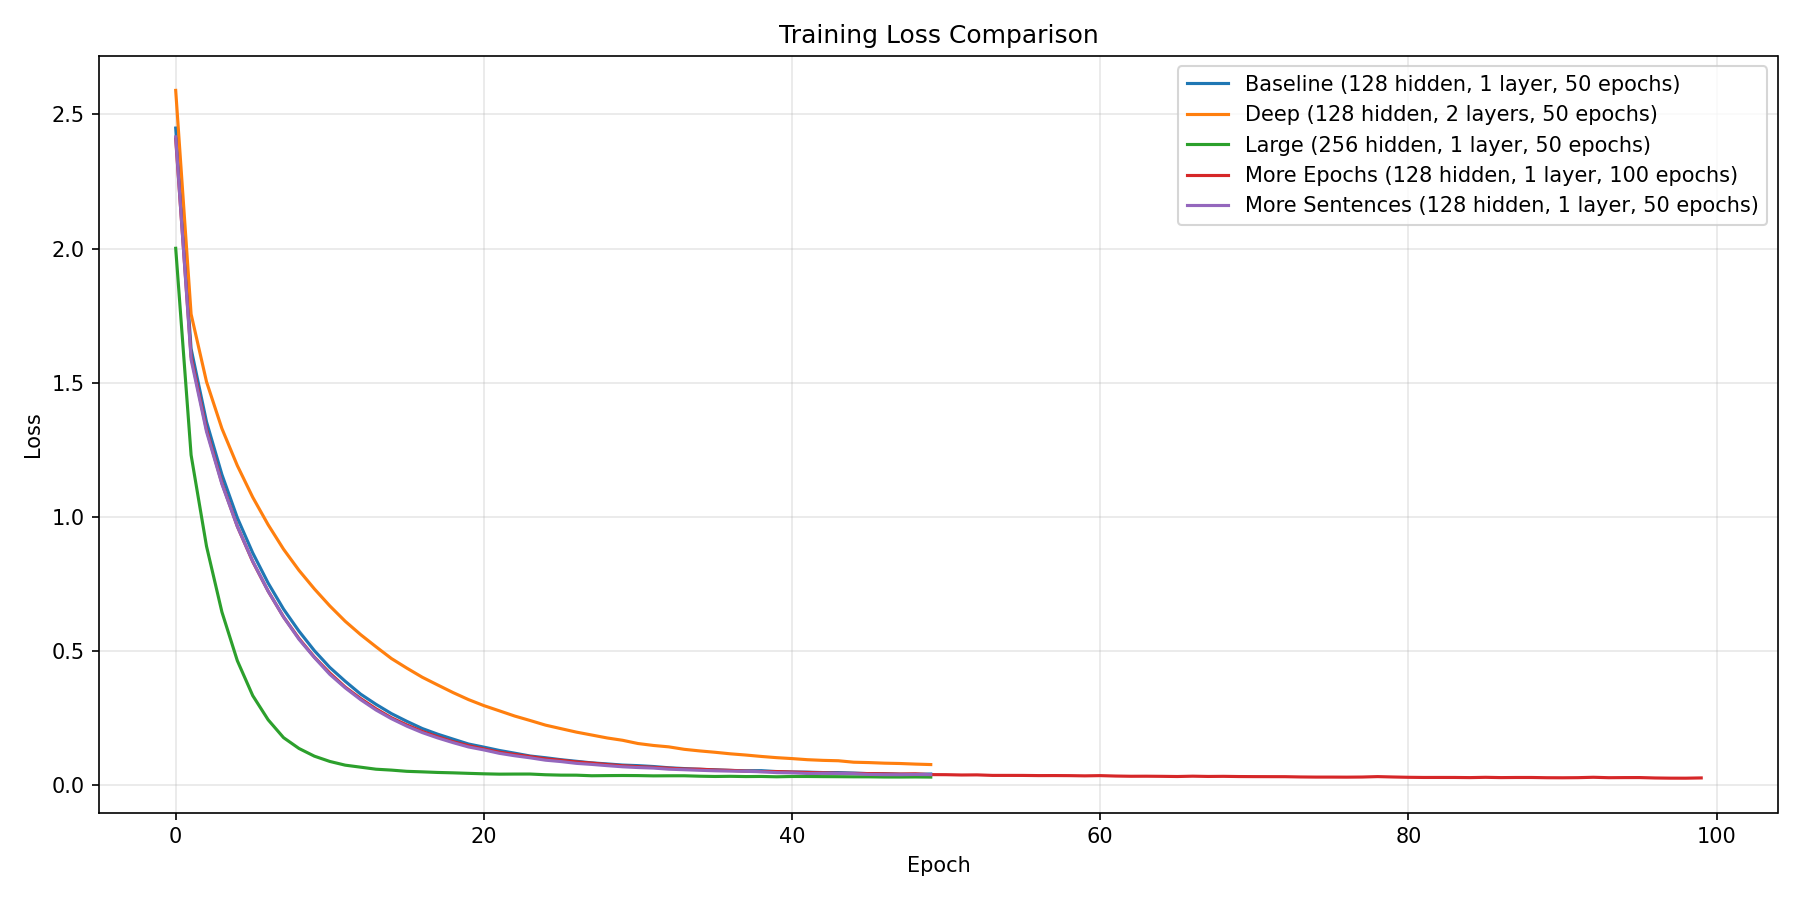

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(losses1, label='Baseline (128 hidden, 1 layer, 50 epochs)')
plt.plot(losses2, label='Deep (128 hidden, 2 layers, 50 epochs)')
plt.plot(losses3, label='Large (256 hidden, 1 layer, 50 epochs)')
plt.plot(losses4, label='More Epochs (128 hidden, 1 layer, 100 epochs)')
plt.plot(losses6, label='More Sentences (128 hidden, 1 layer, 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison.png', dpi=150)
plt.show()
display(Image(filename='comparison.png'))



In [ ]:
!pip install nltk pandas
!python -c "import nltk; nltk.download('punkt')"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
input_lang_es, output_lang_es, pairs_es = prepareData('eng', 'spa', True)  # Reverse для Spanish→English
print(random.choice(pairs_es))